In [1]:
# ============================================================
# FEATURE ENGINEERING & EXPLORATORY DATA ANALYSIS (EDA)
# Phase 3 - Advanced Analysis & Visualization
# ============================================================

print("🎨 Starting Feature Engineering & EDA")
print("=" * 70)

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully!")
print("=" * 70)

🎨 Starting Feature Engineering & EDA
✅ Libraries imported successfully!


In [2]:
# ============================================================
# STEP 1: LOAD CLEANED DATA
# ============================================================

print("\n📂 Loading Cleaned Dataset...")
print("=" * 70)

# Load the cleaned data
df = pd.read_csv('../data/processed/ecommerce_data_cleaned.csv')

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"✅ Dataset loaded successfully!")
print(f"   - Rows: {len(df):,}")
print(f"   - Columns: {len(df.columns)}")
print(f"   - Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n📊 Dataset Info:")
print("-" * 70)
df.info()

print("\n📋 First 5 Rows:")
print("-" * 70)
print(df.head())

print("\n" + "=" * 70)


📂 Loading Cleaned Dataset...
✅ Dataset loaded successfully!
   - Rows: 401,564
   - Columns: 16
   - Memory: 167.86 MB

📊 Dataset Info:
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401564 entries, 0 to 401563
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401564 non-null  object        
 1   StockCode    401564 non-null  object        
 2   Description  401564 non-null  object        
 3   Quantity     401564 non-null  int64         
 4   InvoiceDate  401564 non-null  datetime64[ns]
 5   UnitPrice    401564 non-null  float64       
 6   CustomerID   401564 non-null  int64         
 7   Country      401564 non-null  object        
 8   TotalAmount  401564 non-null  float64       
 9   Year         401564 non-null  int64         
 10  Month        401564 non-null  int64         
 11  Day          401564 non-nu

In [3]:
# ============================================================
# STEP 2: FEATURE ENGINEERING - PART 1 (RFM FEATURES)
# ============================================================

print("\n🔧 FEATURE ENGINEERING - PART 1: RFM ANALYSIS")
print("=" * 70)

# Set reference date (last date in dataset + 1 day)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Reference Date: {reference_date}")

# Calculate RFM for each customer
print("\n1️⃣ Calculating RFM Metrics...")

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalAmount': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print(f"   ✅ RFM calculated for {len(rfm):,} customers")

# Merge RFM back to main dataframe
df = df.merge(rfm, on='CustomerID', how='left')

print("\n📊 RFM Statistics:")
print(rfm.describe())

print("\n✅ RFM Features Added:")
print("   - Recency: Days since last purchase")
print("   - Frequency: Number of orders")
print("   - Monetary: Total purchase value")

print("\n" + "=" * 70)


🔧 FEATURE ENGINEERING - PART 1: RFM ANALYSIS
Reference Date: 2011-12-10 12:50:00

1️⃣ Calculating RFM Metrics...
   ✅ RFM calculated for 4,371 customers

📊 RFM Statistics:
       CustomerID  Recency  Frequency  Monetary
count     4371.00  4371.00    4371.00   4371.00
mean     15300.15    92.06       5.08   1893.96
std       1722.31   100.77       9.33   8219.59
min      12346.00     1.00       1.00  -4287.63
25%      13813.50    17.00       1.00    291.94
50%      15301.00    50.00       3.00    644.24
75%      16778.50   143.00       5.00   1608.94
max      18287.00   374.00     248.00 279489.02

✅ RFM Features Added:
   - Recency: Days since last purchase
   - Frequency: Number of orders
   - Monetary: Total purchase value



In [4]:
# ============================================================
# STEP 3: FEATURE ENGINEERING - PART 2 (TIME-BASED FEATURES)
# ============================================================

print("\n🔧 FEATURE ENGINEERING - PART 2: TIME-BASED FEATURES")
print("=" * 70)

print("\n1️⃣ Creating Time-Based Features...")

# Extract time components (if not already present)
if 'Year' not in df.columns:
    df['Year'] = df['InvoiceDate'].dt.year
if 'Month' not in df.columns:
    df['Month'] = df['InvoiceDate'].dt.month
if 'Day' not in df.columns:
    df['Day'] = df['InvoiceDate'].dt.day
if 'DayOfWeek' not in df.columns:
    df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
if 'Hour' not in df.columns:
    df['Hour'] = df['InvoiceDate'].dt.hour
if 'DayName' not in df.columns:
    df['DayName'] = df['InvoiceDate'].dt.day_name()
if 'MonthName' not in df.columns:
    df['MonthName'] = df['InvoiceDate'].dt.month_name()

# Week of year
df['WeekOfYear'] = df['InvoiceDate'].dt.isocalendar().week

# Quarter
df['Quarter'] = df['InvoiceDate'].dt.quarter

# Is Weekend
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Time of Day
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

df['TimeOfDay'] = df['Hour'].apply(get_time_of_day)

# Days since first purchase (customer tenure)
first_purchase = df.groupby('CustomerID')['InvoiceDate'].min().reset_index()
first_purchase.columns = ['CustomerID', 'FirstPurchaseDate']
df = df.merge(first_purchase, on='CustomerID', how='left')
df['CustomerTenure'] = (df['InvoiceDate'] - df['FirstPurchaseDate']).dt.days

print("   ✅ Time-based features created:")
print("      - Year, Month, Day, Hour")
print("      - DayOfWeek, DayName, MonthName")
print("      - WeekOfYear, Quarter")
print("      - IsWeekend, TimeOfDay")
print("      - CustomerTenure")

print("\n" + "=" * 70)


🔧 FEATURE ENGINEERING - PART 2: TIME-BASED FEATURES

1️⃣ Creating Time-Based Features...
   ✅ Time-based features created:
      - Year, Month, Day, Hour
      - DayOfWeek, DayName, MonthName
      - WeekOfYear, Quarter
      - IsWeekend, TimeOfDay
      - CustomerTenure



In [5]:
# ============================================================
# STEP 4: FEATURE ENGINEERING - PART 3 (PRODUCT FEATURES)
# ============================================================

print("\n🔧 FEATURE ENGINEERING - PART 3: PRODUCT FEATURES")
print("=" * 70)

print("\n1️⃣ Creating Product Features...")

# Revenue per item
df['RevenuePerItem'] = df['TotalAmount'] / df['Quantity'].abs()

# Is Return (negative quantity)
df['IsReturn'] = (df['Quantity'] < 0).astype(int)

# Absolute Quantity
df['AbsQuantity'] = df['Quantity'].abs()

# Price Tier
df['PriceTier'] = pd.cut(df['UnitPrice'], 
                          bins=[0, 2, 5, 10, float('inf')],
                          labels=['Budget', 'Mid', 'Premium', 'Luxury'])

# Quantity Tier
df['QuantityTier'] = pd.cut(df['AbsQuantity'],
                             bins=[0, 5, 10, 20, float('inf')],
                             labels=['Small', 'Medium', 'Large', 'Bulk'])

print("   ✅ Product features created:")
print("      - RevenuePerItem")
print("      - IsReturn (flag for returns)")
print("      - AbsQuantity (absolute value)")
print("      - PriceTier (Budget/Mid/Premium/Luxury)")
print("      - QuantityTier (Small/Medium/Large/Bulk)")

print("\n" + "=" * 70)


🔧 FEATURE ENGINEERING - PART 3: PRODUCT FEATURES

1️⃣ Creating Product Features...
   ✅ Product features created:
      - RevenuePerItem
      - IsReturn (flag for returns)
      - AbsQuantity (absolute value)
      - PriceTier (Budget/Mid/Premium/Luxury)
      - QuantityTier (Small/Medium/Large/Bulk)



In [6]:
# ============================================================
# STEP 5: FEATURE ENGINEERING - PART 4 (CUSTOMER FEATURES)
# ============================================================

print("\n🔧 FEATURE ENGINEERING - PART 4: CUSTOMER FEATURES")
print("=" * 70)

print("\n1️⃣ Creating Customer Behavior Features...")

# Average Order Value per customer
avg_order_value = df.groupby('CustomerID')['TotalAmount'].mean().reset_index()
avg_order_value.columns = ['CustomerID', 'AvgOrderValue']
df = df.merge(avg_order_value, on='CustomerID', how='left')

# Total Items Purchased per customer
total_items = df.groupby('CustomerID')['AbsQuantity'].sum().reset_index()
total_items.columns = ['CustomerID', 'TotalItemsPurchased']
df = df.merge(total_items, on='CustomerID', how='left')

# Average Items per Order
df['AvgItemsPerOrder'] = df['TotalItemsPurchased'] / df['Frequency']

# Purchase Velocity (orders per day of tenure)
df['PurchaseVelocity'] = df['Frequency'] / (df['CustomerTenure'] + 1)

# Customer Segment based on RFM
def rfm_segment(row):
    r_score = 5 if row['Recency'] <= 30 else (4 if row['Recency'] <= 60 else (3 if row['Recency'] <= 90 else (2 if row['Recency'] <= 180 else 1)))
    f_score = 5 if row['Frequency'] >= 10 else (4 if row['Frequency'] >= 7 else (3 if row['Frequency'] >= 4 else (2 if row['Frequency'] >= 2 else 1)))
    m_score = 5 if row['Monetary'] >= 5000 else (4 if row['Monetary'] >= 2000 else (3 if row['Monetary'] >= 1000 else (2 if row['Monetary'] >= 500 else 1)))
    
    total_score = r_score + f_score + m_score
    
    if total_score >= 13:
        return 'Champions'
    elif total_score >= 10:
        return 'Loyal'
    elif total_score >= 7:
        return 'Potential'
    else:
        return 'At Risk'

df['RFMSegment'] = df.apply(rfm_segment, axis=1)

print("   ✅ Customer features created:")
print("      - AvgOrderValue")
print("      - TotalItemsPurchased")
print("      - AvgItemsPerOrder")
print("      - PurchaseVelocity")
print("      - RFMSegment (Champions/Loyal/Potential/At Risk)")

print("\n" + "=" * 70)


🔧 FEATURE ENGINEERING - PART 4: CUSTOMER FEATURES

1️⃣ Creating Customer Behavior Features...
   ✅ Customer features created:
      - AvgOrderValue
      - TotalItemsPurchased
      - AvgItemsPerOrder
      - PurchaseVelocity
      - RFMSegment (Champions/Loyal/Potential/At Risk)



In [7]:
# ============================================================
# STEP 6: FEATURE SUMMARY
# ============================================================

print("\n📊 FEATURE ENGINEERING SUMMARY")
print("=" * 70)

print(f"\n✅ Total Features Created: {len(df.columns)}")

print("\n📋 All Features:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

print("\n📈 Dataset Statistics:")
print(f"   - Rows: {len(df):,}")
print(f"   - Columns: {len(df.columns)}")
print(f"   - Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n🔍 Sample of Enhanced Data:")
print("-" * 70)
print(df.head(3))

print("\n💾 Saving Enhanced Dataset...")
df.to_csv('../data/processed/ecommerce_data_enhanced.csv', index=False)
print("   ✅ Saved to: data/processed/ecommerce_data_enhanced.csv")

print("\n" + "=" * 70)
print("🎉 FEATURE ENGINEERING COMPLETE!")
print("=" * 70)


📊 FEATURE ENGINEERING SUMMARY

✅ Total Features Created: 35

📋 All Features:
    1. InvoiceNo
    2. StockCode
    3. Description
    4. Quantity
    5. InvoiceDate
    6. UnitPrice
    7. CustomerID
    8. Country
    9. TotalAmount
   10. Year
   11. Month
   12. Day
   13. DayOfWeek
   14. Hour
   15. DayName
   16. MonthName
   17. Recency
   18. Frequency
   19. Monetary
   20. WeekOfYear
   21. Quarter
   22. IsWeekend
   23. TimeOfDay
   24. FirstPurchaseDate
   25. CustomerTenure
   26. RevenuePerItem
   27. IsReturn
   28. AbsQuantity
   29. PriceTier
   30. QuantityTier
   31. AvgOrderValue
   32. TotalItemsPurchased
   33. AvgItemsPerOrder
   34. PurchaseVelocity
   35. RFMSegment

📈 Dataset Statistics:
   - Rows: 401,564
   - Columns: 35
   - Memory: 255.64 MB

🔍 Sample of Enhanced Data:
----------------------------------------------------------------------
  InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  White Hanging Heart T-L


📊 UNIVARIATE ANALYSIS - DISTRIBUTIONS


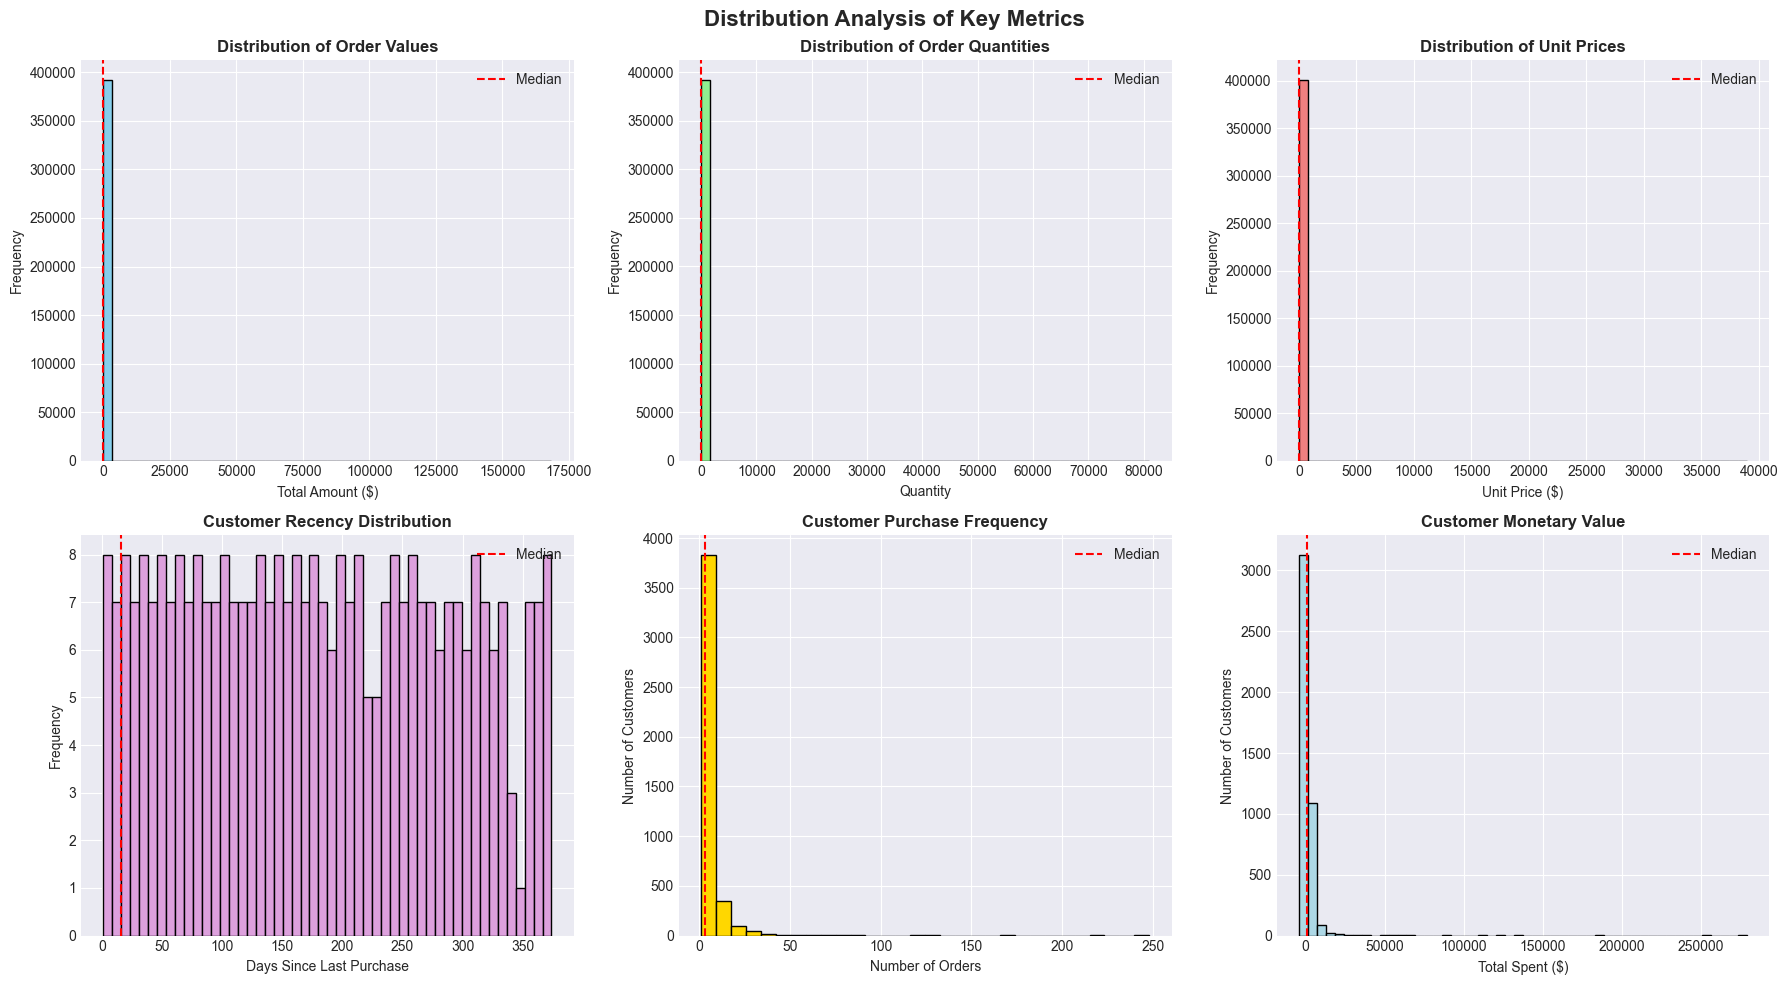

✅ Distribution plots created and saved!



In [8]:
# ============================================================
# STEP 7: UNIVARIATE ANALYSIS - DISTRIBUTIONS
# ============================================================

print("\n📊 UNIVARIATE ANALYSIS - DISTRIBUTIONS")
print("=" * 70)

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution Analysis of Key Metrics', fontsize=16, fontweight='bold')

# 1. Distribution of Order Values
axes[0, 0].hist(df[df['TotalAmount'] > 0]['TotalAmount'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Order Values', fontweight='bold')
axes[0, 0].set_xlabel('Total Amount ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df[df['TotalAmount'] > 0]['TotalAmount'].median(), color='red', linestyle='--', label='Median')
axes[0, 0].legend()

# 2. Distribution of Quantity
axes[0, 1].hist(df[df['Quantity'] > 0]['Quantity'], bins=50, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Distribution of Order Quantities', fontweight='bold')
axes[0, 1].set_xlabel('Quantity')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df[df['Quantity'] > 0]['Quantity'].median(), color='red', linestyle='--', label='Median')
axes[0, 1].legend()

# 3. Distribution of Unit Price
axes[0, 2].hist(df['UnitPrice'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 2].set_title('Distribution of Unit Prices', fontweight='bold')
axes[0, 2].set_xlabel('Unit Price ($)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(df['UnitPrice'].median(), color='red', linestyle='--', label='Median')
axes[0, 2].legend()

# 4. Distribution of Recency
axes[1, 0].hist(df['Recency'].unique(), bins=50, color='plum', edgecolor='black')
axes[1, 0].set_title('Customer Recency Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Days Since Last Purchase')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(df['Recency'].median(), color='red', linestyle='--', label='Median')
axes[1, 0].legend()

# 5. Distribution of Frequency
frequency_data = df.groupby('CustomerID')['Frequency'].first()
axes[1, 1].hist(frequency_data, bins=30, color='gold', edgecolor='black')
axes[1, 1].set_title('Customer Purchase Frequency', fontweight='bold')
axes[1, 1].set_xlabel('Number of Orders')
axes[1, 1].set_ylabel('Number of Customers')
axes[1, 1].axvline(frequency_data.median(), color='red', linestyle='--', label='Median')
axes[1, 1].legend()

# 6. Distribution of Monetary Value
monetary_data = df.groupby('CustomerID')['Monetary'].first()
axes[1, 2].hist(monetary_data, bins=50, color='lightblue', edgecolor='black')
axes[1, 2].set_title('Customer Monetary Value', fontweight='bold')
axes[1, 2].set_xlabel('Total Spent ($)')
axes[1, 2].set_ylabel('Number of Customers')
axes[1, 2].axvline(monetary_data.median(), color='red', linestyle='--', label='Median')
axes[1, 2].legend()

plt.tight_layout()
plt.savefig('../images/results/distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Distribution plots created and saved!")
print("\n" + "=" * 70)


📦 BOX PLOTS - OUTLIER DETECTION


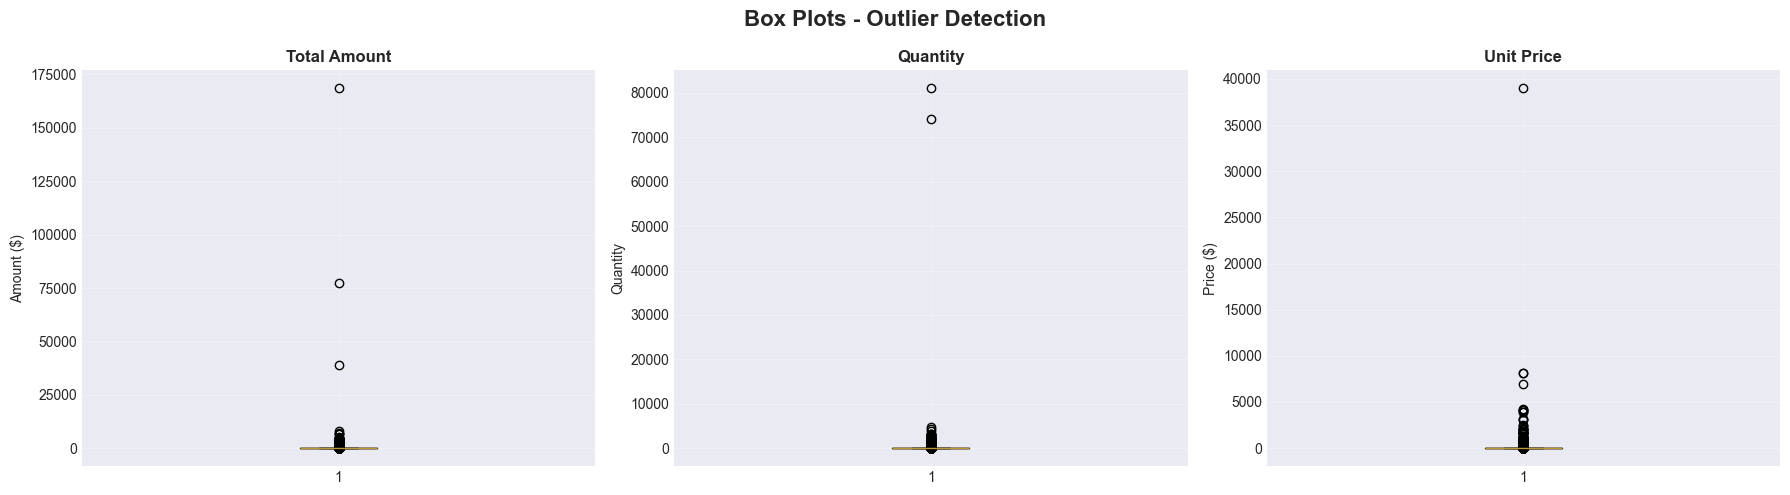

✅ Box plots created and saved!

📊 Outlier Statistics:
----------------------------------------------------------------------
TotalAmount    : 32,938 outliers (8.20%)
Quantity       : 26,637 outliers (6.63%)
UnitPrice      : 35,802 outliers (8.92%)



In [9]:
# ============================================================
# STEP 8: BOX PLOTS FOR OUTLIER DETECTION
# ============================================================

print("\n📦 BOX PLOTS - OUTLIER DETECTION")
print("=" * 70)

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Box Plots - Outlier Detection', fontsize=16, fontweight='bold')

# 1. Total Amount Box Plot
axes[0].boxplot(df[df['TotalAmount'] > 0]['TotalAmount'], vert=True)
axes[0].set_title('Total Amount', fontweight='bold')
axes[0].set_ylabel('Amount ($)')
axes[0].grid(True, alpha=0.3)

# 2. Quantity Box Plot
axes[1].boxplot(df[df['Quantity'] > 0]['Quantity'], vert=True)
axes[1].set_title('Quantity', fontweight='bold')
axes[1].set_ylabel('Quantity')
axes[1].grid(True, alpha=0.3)

# 3. Unit Price Box Plot
axes[2].boxplot(df['UnitPrice'], vert=True)
axes[2].set_title('Unit Price', fontweight='bold')
axes[2].set_ylabel('Price ($)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/results/boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Box plots created and saved!")

# Print outlier statistics
print("\n📊 Outlier Statistics:")
print("-" * 70)

def detect_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers), (len(outliers) / len(df)) * 100

for col in ['TotalAmount', 'Quantity', 'UnitPrice']:
    if col in df.columns:
        outlier_count, outlier_pct = detect_outliers(col)
        print(f"{col:15s}: {outlier_count:,} outliers ({outlier_pct:.2f}%)")

print("\n" + "=" * 70)


📊 CATEGORICAL VARIABLE ANALYSIS


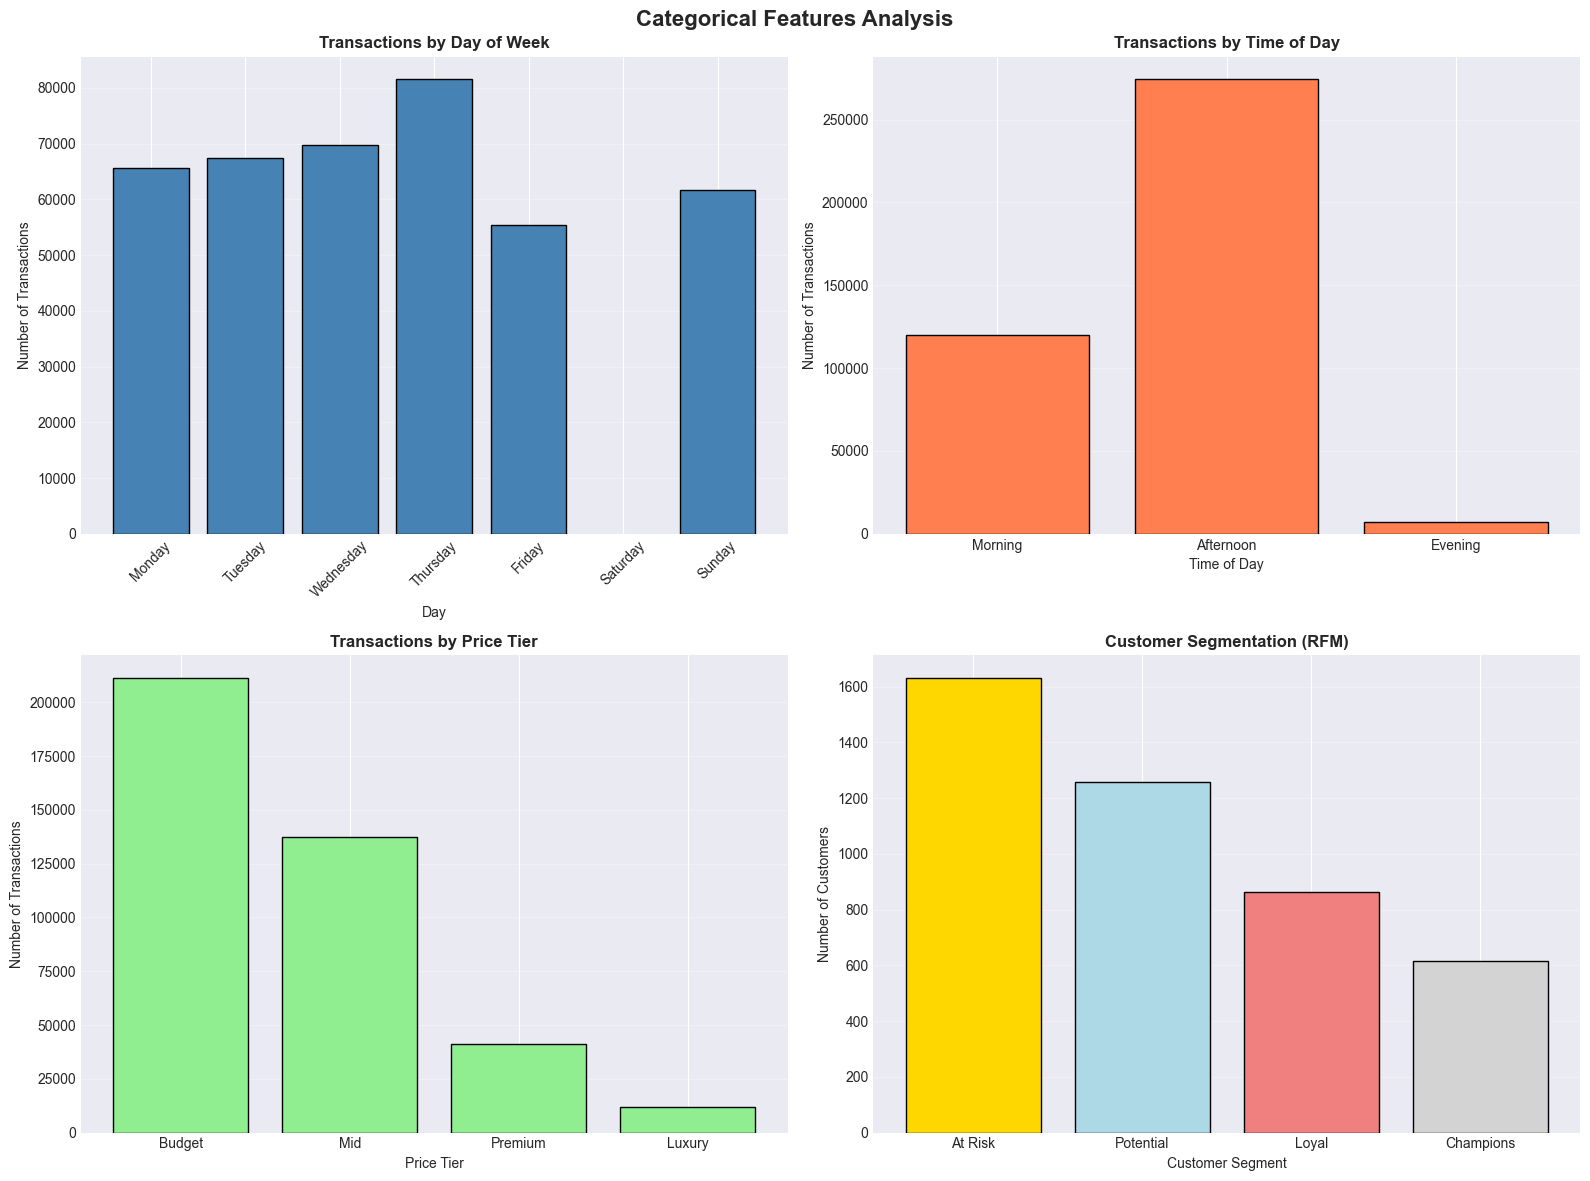

✅ Categorical analysis plots created and saved!



In [10]:
# ============================================================
# STEP 9: CATEGORICAL VARIABLE ANALYSIS
# ============================================================

print("\n📊 CATEGORICAL VARIABLE ANALYSIS")
print("=" * 70)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Categorical Features Analysis', fontsize=16, fontweight='bold')

# 1. Day of Week Distribution
day_counts = df['DayName'].value_counts()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = day_counts.reindex(day_order)
axes[0, 0].bar(day_counts.index, day_counts.values, color='steelblue', edgecolor='black')
axes[0, 0].set_title('Transactions by Day of Week', fontweight='bold')
axes[0, 0].set_xlabel('Day')
axes[0, 0].set_ylabel('Number of Transactions')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Time of Day Distribution
time_counts = df['TimeOfDay'].value_counts()
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
time_counts = time_counts.reindex(time_order)
axes[0, 1].bar(time_counts.index, time_counts.values, color='coral', edgecolor='black')
axes[0, 1].set_title('Transactions by Time of Day', fontweight='bold')
axes[0, 1].set_xlabel('Time of Day')
axes[0, 1].set_ylabel('Number of Transactions')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Price Tier Distribution
price_tier_counts = df['PriceTier'].value_counts()
axes[1, 0].bar(price_tier_counts.index, price_tier_counts.values, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Transactions by Price Tier', fontweight='bold')
axes[1, 0].set_xlabel('Price Tier')
axes[1, 0].set_ylabel('Number of Transactions')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. RFM Segment Distribution
rfm_counts = df.groupby('CustomerID')['RFMSegment'].first().value_counts()
colors_rfm = ['gold', 'lightblue', 'lightcoral', 'lightgray']
axes[1, 1].bar(rfm_counts.index, rfm_counts.values, color=colors_rfm, edgecolor='black')
axes[1, 1].set_title('Customer Segmentation (RFM)', fontweight='bold')
axes[1, 1].set_xlabel('Customer Segment')
axes[1, 1].set_ylabel('Number of Customers')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../images/results/categorical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Categorical analysis plots created and saved!")
print("\n" + "=" * 70)

In [11]:
# ============================================================
# STEP 10: STATISTICAL SUMMARY
# ============================================================

print("\n📈 STATISTICAL SUMMARY")
print("=" * 70)

print("\n1️⃣ KEY METRICS SUMMARY:")
print("-" * 70)

metrics = {
    'Total Transactions': len(df),
    'Unique Customers': df['CustomerID'].nunique(),
    'Unique Products': df['StockCode'].nunique(),
    'Date Range': f"{df['InvoiceDate'].min().date()} to {df['InvoiceDate'].max().date()}",
    'Total Revenue': f"${df['TotalAmount'].sum():,.2f}",
    'Average Order Value': f"${df.groupby('InvoiceNo')['TotalAmount'].sum().mean():,.2f}",
    'Average Items per Order': f"{df.groupby('InvoiceNo')['Quantity'].sum().mean():.2f}",
    'Return Rate': f"{(df['IsReturn'].sum() / len(df) * 100):.2f}%"
}

for key, value in metrics.items():
    print(f"{key:25s}: {value}")

print("\n2️⃣ CUSTOMER METRICS:")
print("-" * 70)
customer_data = df.groupby('CustomerID').agg({
    'Recency': 'first',
    'Frequency': 'first',
    'Monetary': 'first'
})

print(f"Average Recency        : {customer_data['Recency'].mean():.2f} days")
print(f"Average Frequency      : {customer_data['Frequency'].mean():.2f} orders")
print(f"Average Monetary Value : ${customer_data['Monetary'].mean():,.2f}")
print(f"Median Monetary Value  : ${customer_data['Monetary'].median():,.2f}")

print("\n3️⃣ RFM SEGMENT BREAKDOWN:")
print("-" * 70)
segment_summary = df.groupby(['CustomerID', 'RFMSegment']).first().reset_index()
segment_stats = segment_summary.groupby('RFMSegment').agg({
    'CustomerID': 'count',
    'Monetary': 'mean'
}).round(2)
segment_stats.columns = ['Customer Count', 'Avg Monetary Value']
print(segment_stats)

print("\n" + "=" * 70)


📈 STATISTICAL SUMMARY

1️⃣ KEY METRICS SUMMARY:
----------------------------------------------------------------------
Total Transactions       : 401564
Unique Customers         : 4371
Unique Products          : 3684
Date Range               : 2010-12-01 to 2011-12-09
Total Revenue            : $8,278,519.42
Average Order Value      : $373.14
Average Items per Order  : 219.91
Return Rate              : 2.21%

2️⃣ CUSTOMER METRICS:
----------------------------------------------------------------------
Average Recency        : 92.06 days
Average Frequency      : 5.08 orders
Average Monetary Value : $1,893.96
Median Monetary Value  : $644.24

3️⃣ RFM SEGMENT BREAKDOWN:
----------------------------------------------------------------------
            Customer Count  Avg Monetary Value
RFMSegment                                    
At Risk               1631              337.76
Champions              617             8466.55
Loyal                  865             1788.57
Potential         


🔗 CORRELATION ANALYSIS


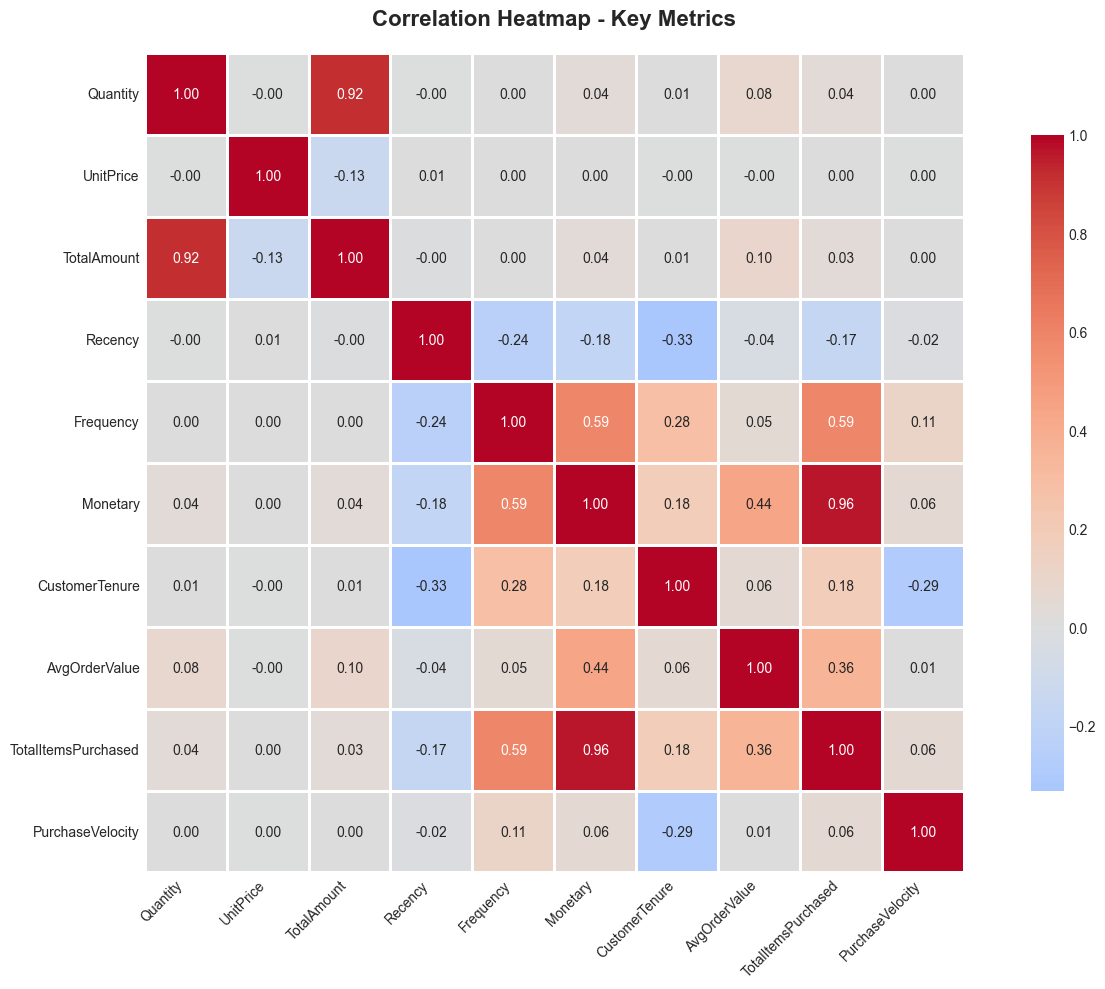

✅ Correlation heatmap created and saved!

📊 Strong Correlations (|r| > 0.5):
----------------------------------------------------------------------
         Variable 1 Variable 2  Correlation
TotalItemsPurchased   Monetary         0.96
        TotalAmount   Quantity         0.92
TotalItemsPurchased  Frequency         0.59
           Monetary  Frequency         0.59



In [12]:
# ============================================================
# STEP 11: CORRELATION ANALYSIS
# ============================================================

print("\n🔗 CORRELATION ANALYSIS")
print("=" * 70)

# Select numeric columns for correlation
numeric_cols = ['Quantity', 'UnitPrice', 'TotalAmount', 'Recency', 
                'Frequency', 'Monetary', 'CustomerTenure', 'AvgOrderValue',
                'TotalItemsPurchased', 'PurchaseVelocity']

# Filter to columns that exist
numeric_cols = [col for col in numeric_cols if col in df.columns]

# Create correlation matrix
correlation_matrix = df[numeric_cols].corr()

# Create heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - Key Metrics', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../images/results/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Correlation heatmap created and saved!")

# Print strong correlations
print("\n📊 Strong Correlations (|r| > 0.5):")
print("-" * 70)

# Get upper triangle of correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
correlation_matrix_masked = correlation_matrix.mask(mask)

# Find strong correlations
strong_corr = []
for i in range(len(correlation_matrix_masked)):
    for j in range(len(correlation_matrix_masked)):
        if abs(correlation_matrix_masked.iloc[i, j]) > 0.5:
            strong_corr.append({
                'Variable 1': correlation_matrix_masked.index[i],
                'Variable 2': correlation_matrix_masked.columns[j],
                'Correlation': correlation_matrix_masked.iloc[i, j]
            })

if strong_corr:
    strong_corr_df = pd.DataFrame(strong_corr).sort_values('Correlation', ascending=False)
    print(strong_corr_df.to_string(index=False))
else:
    print("No strong correlations found (threshold: |r| > 0.5)")

print("\n" + "=" * 70)


📊 SCATTER PLOTS - BIVARIATE RELATIONSHIPS


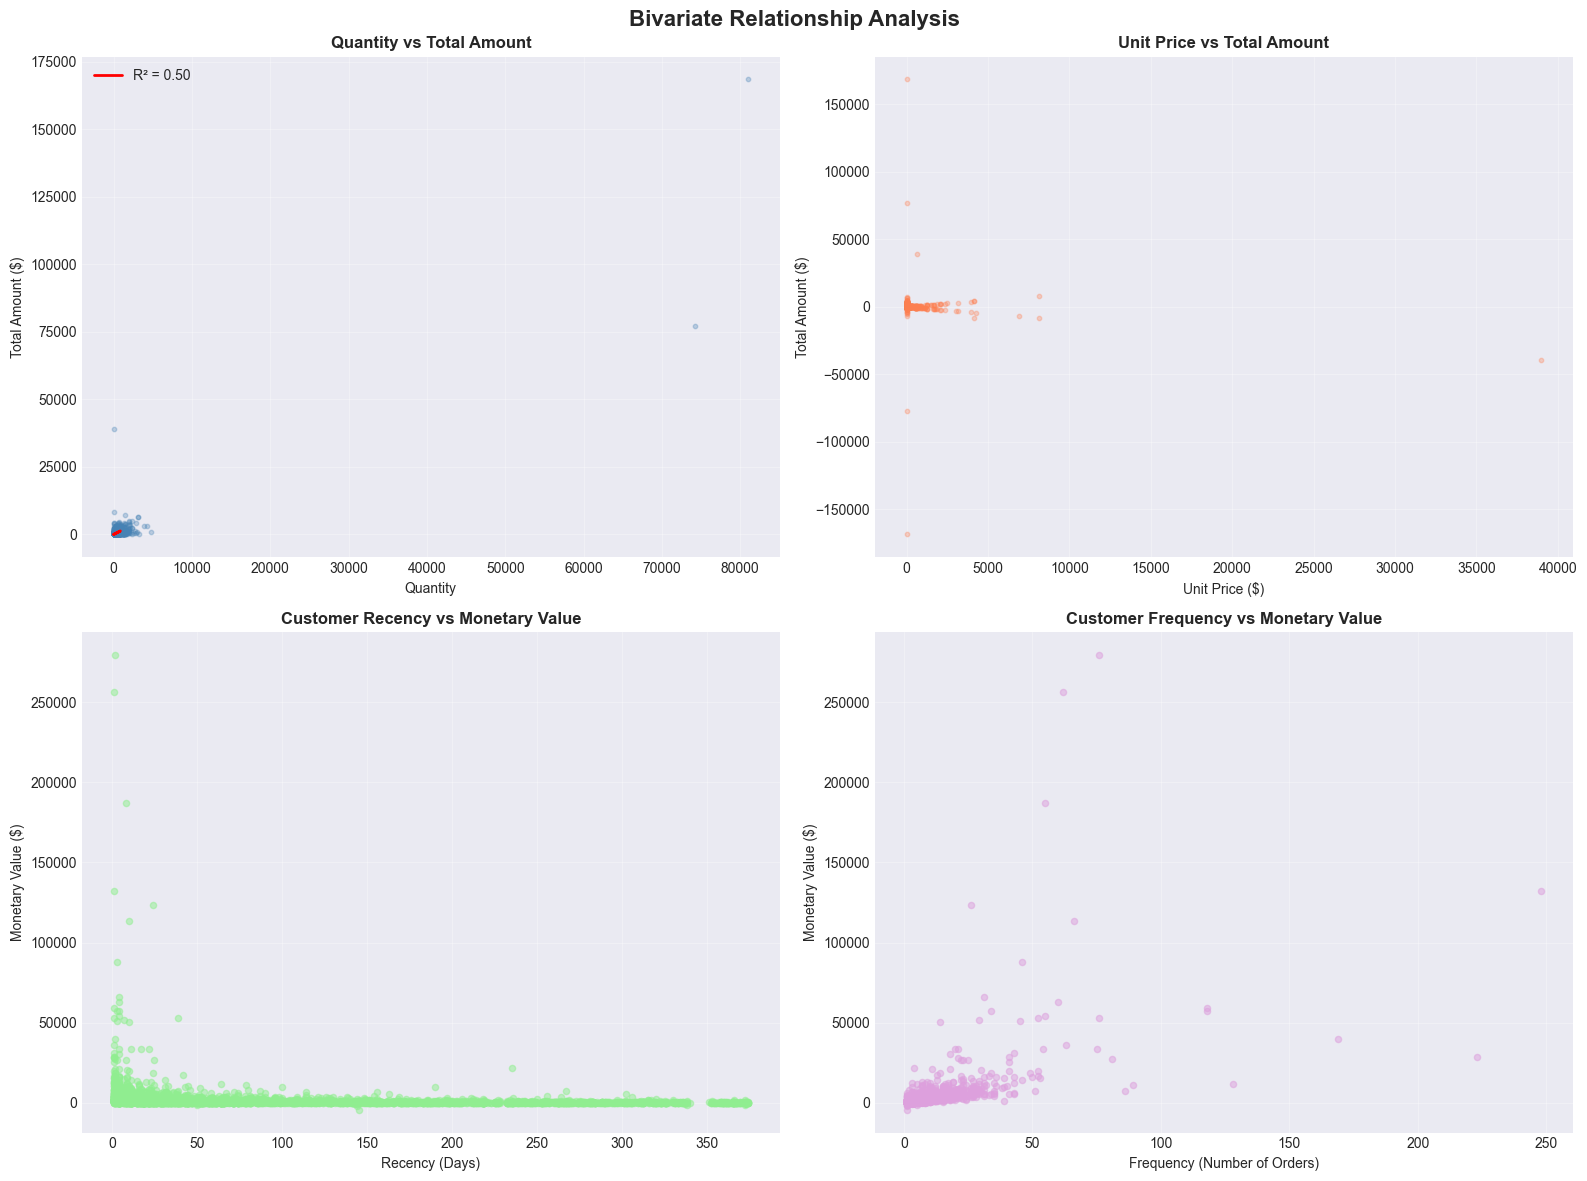

✅ Scatter plots created and saved!



In [13]:
# ============================================================
# STEP 12: SCATTER PLOTS - BIVARIATE RELATIONSHIPS
# ============================================================

print("\n📊 SCATTER PLOTS - BIVARIATE RELATIONSHIPS")
print("=" * 70)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Bivariate Relationship Analysis', fontsize=16, fontweight='bold')

# 1. Quantity vs Total Amount
axes[0, 0].scatter(df[df['Quantity'] > 0]['Quantity'], 
                   df[df['Quantity'] > 0]['TotalAmount'], 
                   alpha=0.3, c='steelblue', s=10)
axes[0, 0].set_title('Quantity vs Total Amount', fontweight='bold')
axes[0, 0].set_xlabel('Quantity')
axes[0, 0].set_ylabel('Total Amount ($)')
axes[0, 0].grid(True, alpha=0.3)

# Add trend line
from scipy import stats
x = df[df['Quantity'] > 0]['Quantity']
y = df[df['Quantity'] > 0]['TotalAmount']
# Sample data for trend line (to avoid memory issues)
sample_size = min(10000, len(x))
x_sample = x.sample(sample_size, random_state=42)
y_sample = y.loc[x_sample.index]
slope, intercept, r_value, p_value, std_err = stats.linregress(x_sample, y_sample)
line = slope * x_sample + intercept
axes[0, 0].plot(x_sample, line, 'r', linewidth=2, label=f'R² = {r_value**2:.2f}')
axes[0, 0].legend()

# 2. Unit Price vs Total Amount
axes[0, 1].scatter(df['UnitPrice'], 
                   df['TotalAmount'], 
                   alpha=0.3, c='coral', s=10)
axes[0, 1].set_title('Unit Price vs Total Amount', fontweight='bold')
axes[0, 1].set_xlabel('Unit Price ($)')
axes[0, 1].set_ylabel('Total Amount ($)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Recency vs Monetary (Customer level)
customer_rfm = df.groupby('CustomerID')[['Recency', 'Monetary']].first()
axes[1, 0].scatter(customer_rfm['Recency'], 
                   customer_rfm['Monetary'], 
                   alpha=0.5, c='lightgreen', s=20)
axes[1, 0].set_title('Customer Recency vs Monetary Value', fontweight='bold')
axes[1, 0].set_xlabel('Recency (Days)')
axes[1, 0].set_ylabel('Monetary Value ($)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Frequency vs Monetary (Customer level)
customer_fm = df.groupby('CustomerID')[['Frequency', 'Monetary']].first()
axes[1, 1].scatter(customer_fm['Frequency'], 
                   customer_fm['Monetary'], 
                   alpha=0.5, c='plum', s=20)
axes[1, 1].set_title('Customer Frequency vs Monetary Value', fontweight='bold')
axes[1, 1].set_xlabel('Frequency (Number of Orders)')
axes[1, 1].set_ylabel('Monetary Value ($)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/results/scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Scatter plots created and saved!")
print("\n" + "=" * 70)


📊 CATEGORICAL VS NUMERICAL ANALYSIS


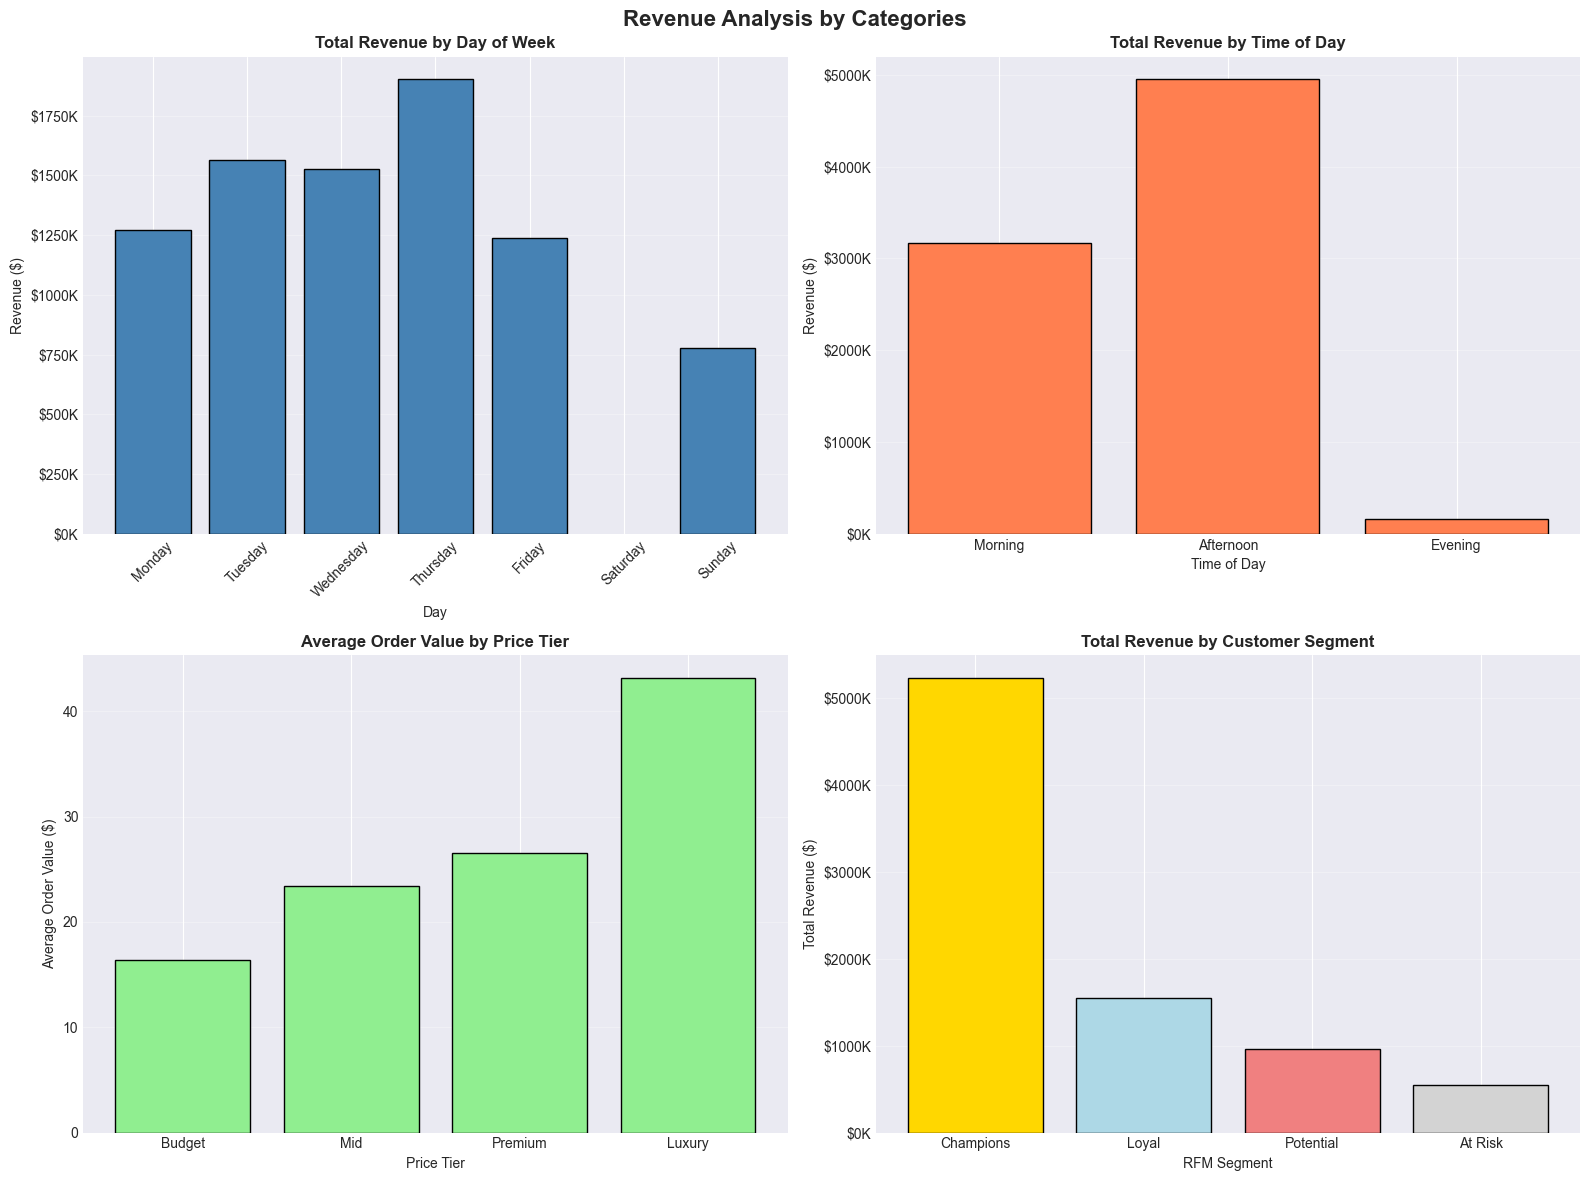

✅ Categorical vs Numerical plots created and saved!



In [14]:
# ============================================================
# STEP 13: CATEGORICAL VS NUMERICAL ANALYSIS
# ============================================================

print("\n📊 CATEGORICAL VS NUMERICAL ANALYSIS")
print("=" * 70)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Revenue Analysis by Categories', fontsize=16, fontweight='bold')

# 1. Revenue by Day of Week
day_revenue = df.groupby('DayName')['TotalAmount'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
axes[0, 0].bar(day_revenue.index, day_revenue.values, color='steelblue', edgecolor='black')
axes[0, 0].set_title('Total Revenue by Day of Week', fontweight='bold')
axes[0, 0].set_xlabel('Day')
axes[0, 0].set_ylabel('Revenue ($)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Format y-axis
axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# 2. Revenue by Time of Day
time_revenue = df.groupby('TimeOfDay')['TotalAmount'].sum().reindex(
    ['Morning', 'Afternoon', 'Evening', 'Night']
)
axes[0, 1].bar(time_revenue.index, time_revenue.values, color='coral', edgecolor='black')
axes[0, 1].set_title('Total Revenue by Time of Day', fontweight='bold')
axes[0, 1].set_xlabel('Time of Day')
axes[0, 1].set_ylabel('Revenue ($)')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# 3. Average Order Value by Price Tier
price_tier_avg = df.groupby('PriceTier')['TotalAmount'].mean()
axes[1, 0].bar(price_tier_avg.index, price_tier_avg.values, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Average Order Value by Price Tier', fontweight='bold')
axes[1, 0].set_xlabel('Price Tier')
axes[1, 0].set_ylabel('Average Order Value ($)')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Revenue by RFM Segment
segment_revenue = df.groupby(['CustomerID', 'RFMSegment'])['Monetary'].first().reset_index()
segment_revenue_sum = segment_revenue.groupby('RFMSegment')['Monetary'].sum().sort_values(ascending=False)
colors_seg = ['gold', 'lightblue', 'lightcoral', 'lightgray']
axes[1, 1].bar(segment_revenue_sum.index, segment_revenue_sum.values, color=colors_seg, edgecolor='black')
axes[1, 1].set_title('Total Revenue by Customer Segment', fontweight='bold')
axes[1, 1].set_xlabel('RFM Segment')
axes[1, 1].set_ylabel('Total Revenue ($)')
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.savefig('../images/results/categorical_revenue_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Categorical vs Numerical plots created and saved!")
print("\n" + "=" * 70)

In [15]:
# ============================================================
# STEP 14: KEY INSIGHTS FROM BIVARIATE ANALYSIS
# ============================================================

print("\n💡 KEY INSIGHTS FROM BIVARIATE ANALYSIS")
print("=" * 70)

# 1. Best Day for Revenue
day_revenue = df.groupby('DayName')['TotalAmount'].sum()
best_day = day_revenue.idxmax()
best_day_revenue = day_revenue.max()
print(f"\n1️⃣ BEST PERFORMING DAY:")
print(f"   {best_day}: ${best_day_revenue:,.2f}")

# 2. Best Time for Revenue
time_revenue = df.groupby('TimeOfDay')['TotalAmount'].sum()
best_time = time_revenue.idxmax()
best_time_revenue = time_revenue.max()
print(f"\n2️⃣ BEST PERFORMING TIME:")
print(f"   {best_time}: ${best_time_revenue:,.2f}")

# 3. Most Valuable Segment
segment_data = df.groupby(['CustomerID', 'RFMSegment']).agg({
    'Monetary': 'first'
}).reset_index()
segment_summary = segment_data.groupby('RFMSegment').agg({
    'CustomerID': 'count',
    'Monetary': ['sum', 'mean']
}).round(2)
segment_summary.columns = ['Customer Count', 'Total Revenue', 'Avg Revenue per Customer']
print(f"\n3️⃣ SEGMENT PERFORMANCE:")
print(segment_summary)

# 4. Price Tier Performance
price_tier_stats = df.groupby('PriceTier').agg({
    'TotalAmount': ['count', 'sum', 'mean']
}).round(2)
price_tier_stats.columns = ['Transaction Count', 'Total Revenue', 'Avg Transaction Value']
print(f"\n4️⃣ PRICE TIER PERFORMANCE:")
print(price_tier_stats)

# 5. Weekend vs Weekday
df['IsWeekend_Label'] = df['IsWeekend'].map({0: 'Weekday', 1: 'Weekend'})
weekend_stats = df.groupby('IsWeekend_Label')['TotalAmount'].agg(['count', 'sum', 'mean']).round(2)
weekend_stats.columns = ['Transaction Count', 'Total Revenue', 'Avg Transaction Value']
print(f"\n5️⃣ WEEKEND VS WEEKDAY:")
print(weekend_stats)

print("\n" + "=" * 70)


💡 KEY INSIGHTS FROM BIVARIATE ANALYSIS

1️⃣ BEST PERFORMING DAY:
   Thursday: $1,902,316.05

2️⃣ BEST PERFORMING TIME:
   Afternoon: $4,950,092.12

3️⃣ SEGMENT PERFORMANCE:
            Customer Count  Total Revenue  Avg Revenue per Customer
RFMSegment                                                         
At Risk               1631      550894.03                    337.76
Champions              617     5223859.89                   8466.55
Loyal                  865     1547109.31                   1788.57
Potential             1258      956656.19                    760.46

4️⃣ PRICE TIER PERFORMANCE:
           Transaction Count  Total Revenue  Avg Transaction Value
PriceTier                                                         
Budget                211286     3465802.59                  16.40
Mid                   137368     3212547.39                  23.39
Premium                41230     1096061.84                  26.58
Luxury                 11680      504107.60           


📈 TIME SERIES ANALYSIS - DAILY TRENDS


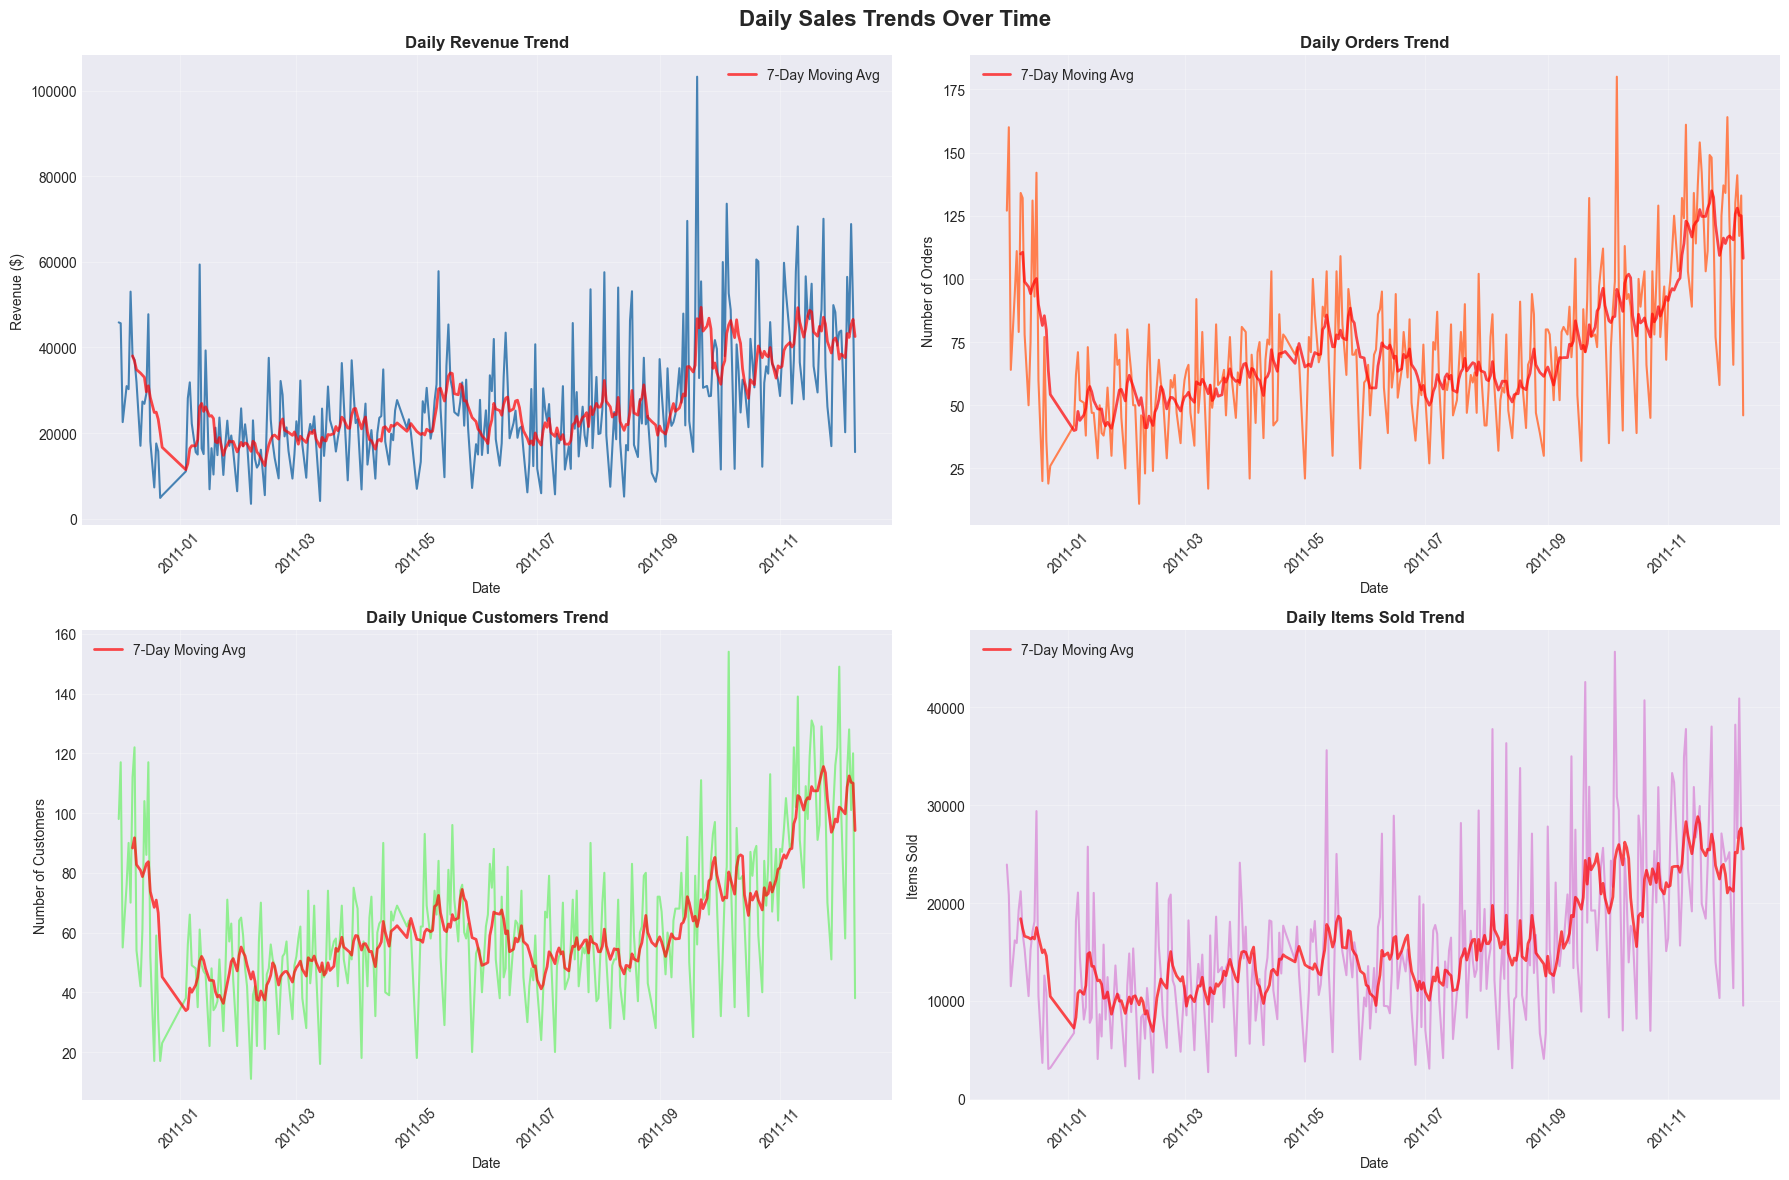

✅ Daily trend plots created and saved!



In [16]:
# ============================================================
# STEP 15: TIME SERIES ANALYSIS - DAILY TRENDS
# ============================================================

print("\n📈 TIME SERIES ANALYSIS - DAILY TRENDS")
print("=" * 70)

# Aggregate by date
daily_sales = df.groupby(df['InvoiceDate'].dt.date).agg({
    'InvoiceNo': 'nunique',
    'CustomerID': 'nunique',
    'TotalAmount': 'sum',
    'Quantity': 'sum'
}).reset_index()

daily_sales.columns = ['Date', 'Orders', 'Customers', 'Revenue', 'Items_Sold']
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Daily Sales Trends Over Time', fontsize=16, fontweight='bold')

# 1. Daily Revenue Trend
axes[0, 0].plot(daily_sales['Date'], daily_sales['Revenue'], color='steelblue', linewidth=1.5)
axes[0, 0].set_title('Daily Revenue Trend', fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Revenue ($)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Add 7-day moving average
daily_sales['Revenue_MA7'] = daily_sales['Revenue'].rolling(window=7).mean()
axes[0, 0].plot(daily_sales['Date'], daily_sales['Revenue_MA7'], 
                color='red', linewidth=2, label='7-Day Moving Avg', alpha=0.7)
axes[0, 0].legend()

# 2. Daily Orders Trend
axes[0, 1].plot(daily_sales['Date'], daily_sales['Orders'], color='coral', linewidth=1.5)
axes[0, 1].set_title('Daily Orders Trend', fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Number of Orders')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Add 7-day moving average
daily_sales['Orders_MA7'] = daily_sales['Orders'].rolling(window=7).mean()
axes[0, 1].plot(daily_sales['Date'], daily_sales['Orders_MA7'], 
                color='red', linewidth=2, label='7-Day Moving Avg', alpha=0.7)
axes[0, 1].legend()

# 3. Daily Customers Trend
axes[1, 0].plot(daily_sales['Date'], daily_sales['Customers'], color='lightgreen', linewidth=1.5)
axes[1, 0].set_title('Daily Unique Customers Trend', fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Number of Customers')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Add 7-day moving average
daily_sales['Customers_MA7'] = daily_sales['Customers'].rolling(window=7).mean()
axes[1, 0].plot(daily_sales['Date'], daily_sales['Customers_MA7'], 
                color='red', linewidth=2, label='7-Day Moving Avg', alpha=0.7)
axes[1, 0].legend()

# 4. Daily Items Sold Trend
axes[1, 1].plot(daily_sales['Date'], daily_sales['Items_Sold'], color='plum', linewidth=1.5)
axes[1, 1].set_title('Daily Items Sold Trend', fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Items Sold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

# Add 7-day moving average
daily_sales['Items_MA7'] = daily_sales['Items_Sold'].rolling(window=7).mean()
axes[1, 1].plot(daily_sales['Date'], daily_sales['Items_MA7'], 
                color='red', linewidth=2, label='7-Day Moving Avg', alpha=0.7)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../images/results/daily_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Daily trend plots created and saved!")
print("\n" + "=" * 70)


📊 MONTHLY TRENDS & GROWTH ANALYSIS


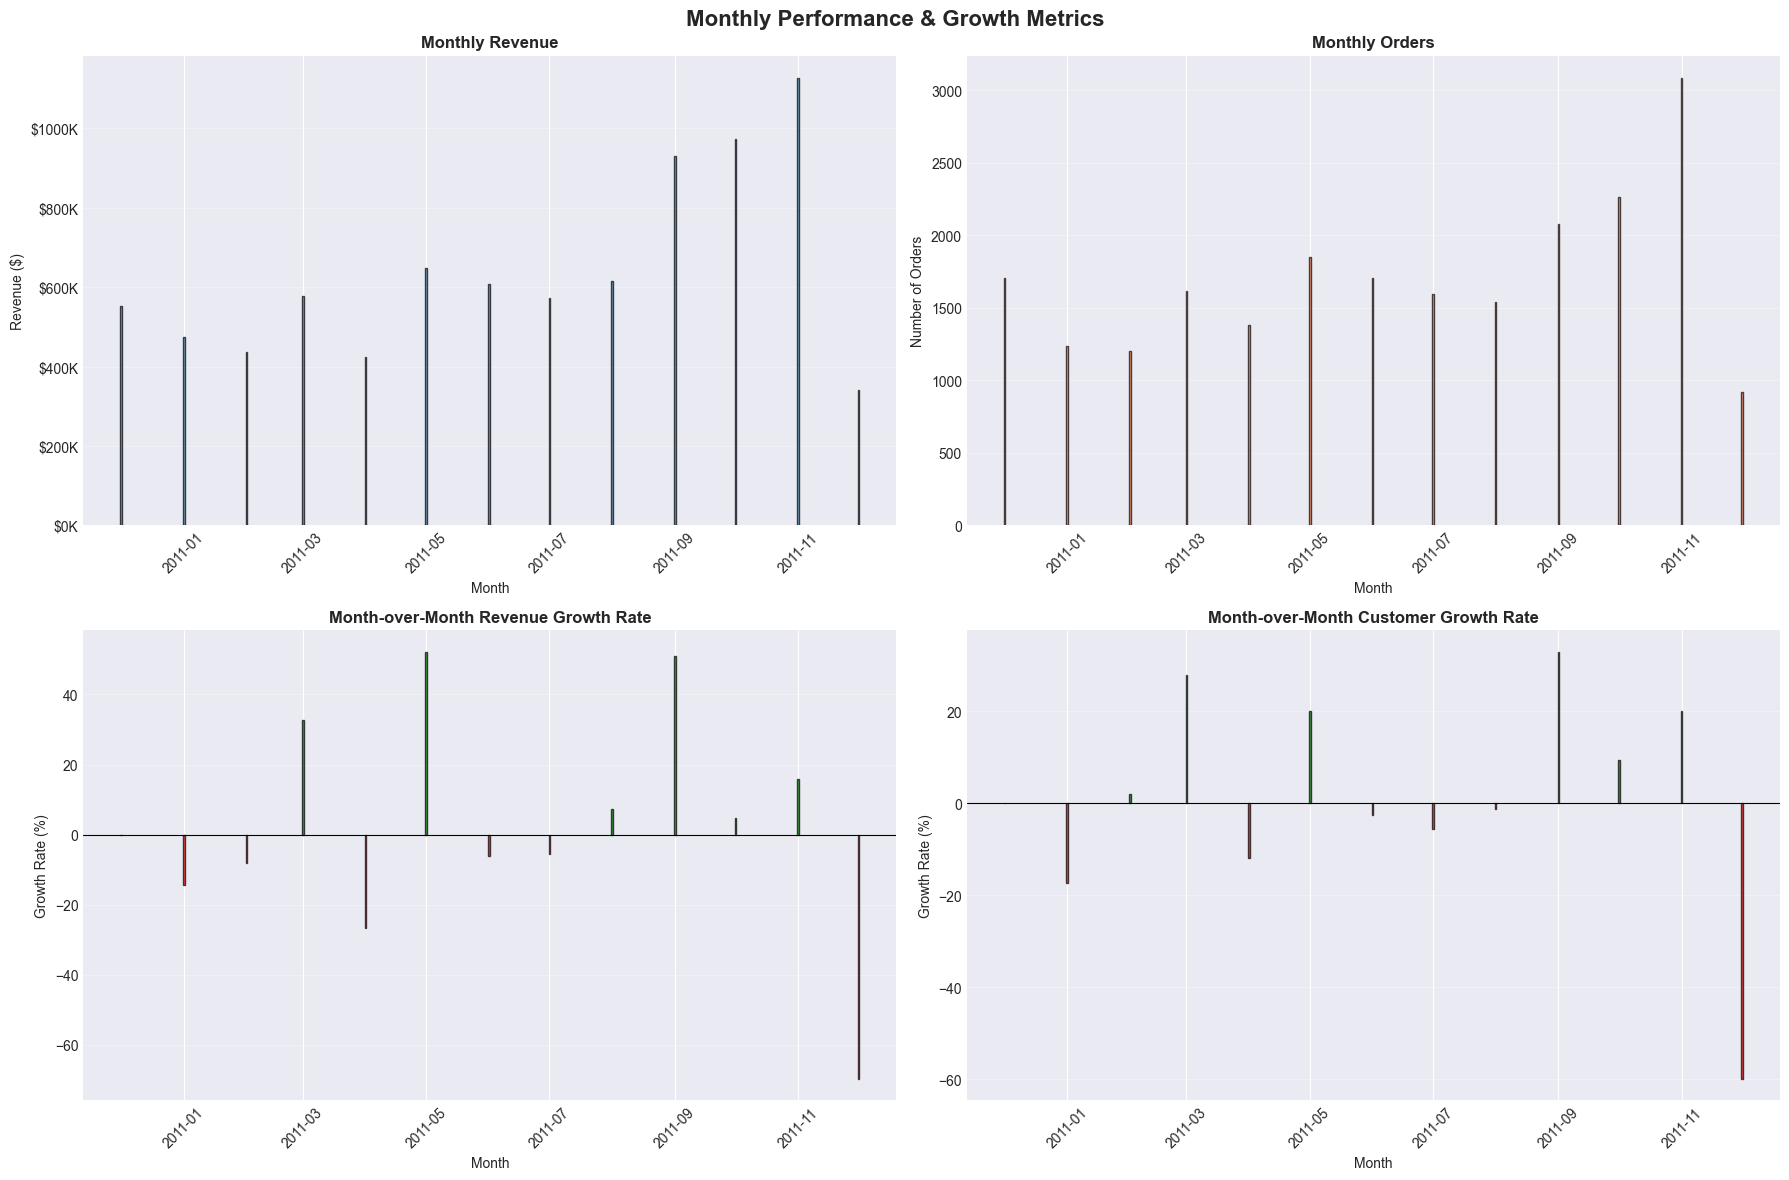

✅ Monthly trend plots created and saved!

📊 MONTHLY PERFORMANCE SUMMARY:
----------------------------------------------------------------------
     Month    Revenue  Orders  Customers  Revenue_Growth  Customer_Growth
2010-12-01  552372.86    1708        948             NaN              NaN
2011-01-01  473731.90    1236        783          -14.24           -17.41
2011-02-01  435534.07    1201        798           -8.06             1.92
2011-03-01  578576.21    1619       1020           32.84            27.82
2011-04-01  425222.67    1384        899          -26.51           -11.86
2011-05-01  647011.67    1849       1079           52.16            20.02
2011-06-01  606862.52    1707       1051           -6.21            -2.59
2011-07-01  573112.32    1593        993           -5.56            -5.52
2011-08-01  615078.09    1543        980            7.32            -1.31
2011-09-01  929356.23    2077       1302           51.10            32.86
2011-10-01  973306.38    2263       1425  

In [17]:
# ============================================================
# STEP 16: MONTHLY AGGREGATION & GROWTH ANALYSIS
# ============================================================

print("\n📊 MONTHLY TRENDS & GROWTH ANALYSIS")
print("=" * 70)

# Aggregate by month
monthly_sales = df.groupby(df['InvoiceDate'].dt.to_period('M')).agg({
    'InvoiceNo': 'nunique',
    'CustomerID': 'nunique',
    'TotalAmount': 'sum',
    'Quantity': 'sum'
}).reset_index()

monthly_sales.columns = ['Month', 'Orders', 'Customers', 'Revenue', 'Items_Sold']
monthly_sales['Month'] = monthly_sales['Month'].dt.to_timestamp()

# Calculate month-over-month growth
monthly_sales['Revenue_Growth'] = monthly_sales['Revenue'].pct_change() * 100
monthly_sales['Customer_Growth'] = monthly_sales['Customers'].pct_change() * 100

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Monthly Performance & Growth Metrics', fontsize=16, fontweight='bold')

# 1. Monthly Revenue
axes[0, 0].bar(monthly_sales['Month'], monthly_sales['Revenue'], 
               color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Monthly Revenue', fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Revenue ($)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# 2. Monthly Orders
axes[0, 1].bar(monthly_sales['Month'], monthly_sales['Orders'], 
               color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Monthly Orders', fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of Orders')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Revenue Growth Rate
colors = ['green' if x > 0 else 'red' for x in monthly_sales['Revenue_Growth'].fillna(0)]
axes[1, 0].bar(monthly_sales['Month'], monthly_sales['Revenue_Growth'].fillna(0), 
               color=colors, edgecolor='black', alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 0].set_title('Month-over-Month Revenue Growth Rate', fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Growth Rate (%)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Customer Growth Rate
colors = ['green' if x > 0 else 'red' for x in monthly_sales['Customer_Growth'].fillna(0)]
axes[1, 1].bar(monthly_sales['Month'], monthly_sales['Customer_Growth'].fillna(0), 
               color=colors, edgecolor='black', alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 1].set_title('Month-over-Month Customer Growth Rate', fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Growth Rate (%)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../images/results/monthly_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Monthly trend plots created and saved!")

# Print monthly summary
print("\n📊 MONTHLY PERFORMANCE SUMMARY:")
print("-" * 70)
print(monthly_sales[['Month', 'Revenue', 'Orders', 'Customers', 'Revenue_Growth', 'Customer_Growth']].to_string(index=False))

print("\n" + "=" * 70)


🌦️ SEASONALITY ANALYSIS


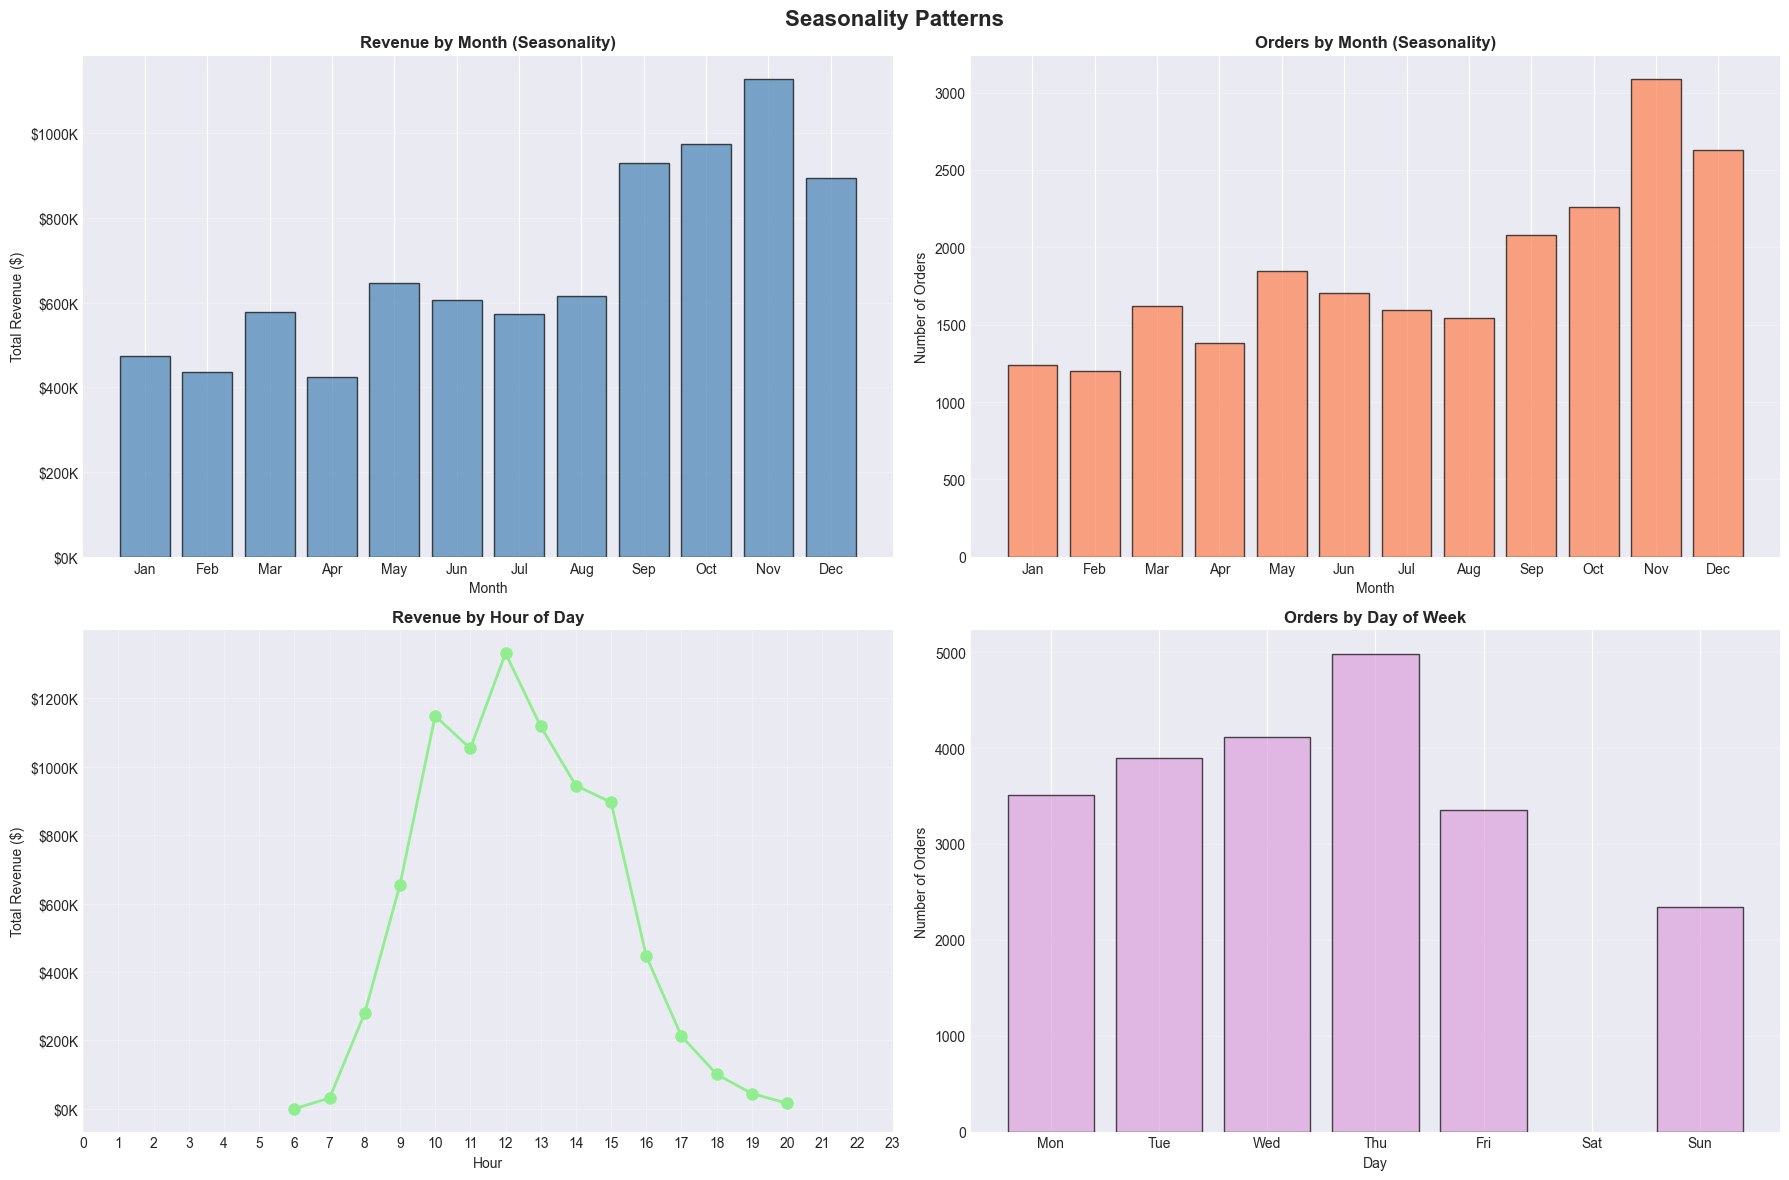

✅ Seasonality analysis plots created and saved!

💡 SEASONALITY KEY FINDINGS:
----------------------------------------------------------------------
Peak Revenue Month: Nov
Lowest Revenue Month: Apr
Peak Hour: 12:00
Peak Day: Thursday



In [18]:
# ============================================================
# STEP 17: SEASONALITY ANALYSIS
# ============================================================

print("\n🌦️ SEASONALITY ANALYSIS")
print("=" * 70)

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Seasonality Patterns', fontsize=16, fontweight='bold')

# 1. Revenue by Month (All years combined)
monthly_pattern = df.groupby('Month')['TotalAmount'].sum().sort_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 0].bar(range(1, 13), monthly_pattern.values, 
               color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Revenue by Month (Seasonality)', fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Total Revenue ($)')
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].set_xticklabels(month_names)
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# 2. Orders by Month
monthly_orders = df.groupby('Month')['InvoiceNo'].nunique().sort_index()
axes[0, 1].bar(range(1, 13), monthly_orders.values, 
               color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Orders by Month (Seasonality)', fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of Orders')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(month_names)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Revenue by Hour
hourly_revenue = df.groupby('Hour')['TotalAmount'].sum().sort_index()
axes[1, 0].plot(hourly_revenue.index, hourly_revenue.values, 
                marker='o', color='lightgreen', linewidth=2, markersize=8)
axes[1, 0].set_title('Revenue by Hour of Day', fontweight='bold')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Total Revenue ($)')
axes[1, 0].set_xticks(range(0, 24))
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# 4. Orders by Day of Week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_orders = df.groupby('DayName')['InvoiceNo'].nunique().reindex(day_order)
axes[1, 1].bar(range(7), dow_orders.values, 
               color='plum', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Orders by Day of Week', fontweight='bold')
axes[1, 1].set_xlabel('Day')
axes[1, 1].set_ylabel('Number of Orders')
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../images/results/seasonality_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Seasonality analysis plots created and saved!")

# Print key findings
print("\n💡 SEASONALITY KEY FINDINGS:")
print("-" * 70)
print(f"Peak Revenue Month: {month_names[monthly_pattern.idxmax()-1]}")
print(f"Lowest Revenue Month: {month_names[monthly_pattern.idxmin()-1]}")
print(f"Peak Hour: {hourly_revenue.idxmax()}:00")
print(f"Peak Day: {dow_orders.idxmax()}")

print("\n" + "=" * 70)

In [19]:
# ============================================================
# STEP 18: TIME SERIES KEY INSIGHTS
# ============================================================

print("\n📊 TIME SERIES KEY INSIGHTS")
print("=" * 70)

# Overall trend
total_revenue = daily_sales['Revenue'].sum()
avg_daily_revenue = daily_sales['Revenue'].mean()
max_daily_revenue = daily_sales['Revenue'].max()
min_daily_revenue = daily_sales['Revenue'].min()

print("\n1️⃣ OVERALL METRICS:")
print("-" * 70)
print(f"Total Revenue (Period): ${total_revenue:,.2f}")
print(f"Average Daily Revenue: ${avg_daily_revenue:,.2f}")
print(f"Max Daily Revenue: ${max_daily_revenue:,.2f}")
print(f"Min Daily Revenue: ${min_daily_revenue:,.2f}")

# Growth metrics
first_month_revenue = monthly_sales['Revenue'].iloc[0]
last_month_revenue = monthly_sales['Revenue'].iloc[-1]
total_growth = ((last_month_revenue - first_month_revenue) / first_month_revenue) * 100

print("\n2️⃣ GROWTH METRICS:")
print("-" * 70)
print(f"First Month Revenue: ${first_month_revenue:,.2f}")
print(f"Last Month Revenue: ${last_month_revenue:,.2f}")
print(f"Total Growth: {total_growth:.2f}%")
print(f"Average Monthly Growth: {monthly_sales['Revenue_Growth'].mean():.2f}%")

# Best performing periods
print("\n3️⃣ BEST PERFORMING PERIODS:")
print("-" * 70)
best_month = monthly_sales.loc[monthly_sales['Revenue'].idxmax()]
print(f"Best Month: {best_month['Month'].strftime('%B %Y')}")
print(f"Revenue: ${best_month['Revenue']:,.2f}")
print(f"Orders: {best_month['Orders']:,}")
print(f"Customers: {best_month['Customers']:,}")

print("\n" + "=" * 70)


📊 TIME SERIES KEY INSIGHTS

1️⃣ OVERALL METRICS:
----------------------------------------------------------------------
Total Revenue (Period): $8,278,519.42
Average Daily Revenue: $27,142.69
Max Daily Revenue: $103,327.13
Min Daily Revenue: $3,439.67

2️⃣ GROWTH METRICS:
----------------------------------------------------------------------
First Month Revenue: $552,372.86
Last Month Revenue: $341,539.43
Total Growth: -38.17%
Average Monthly Growth: 2.80%

3️⃣ BEST PERFORMING PERIODS:
----------------------------------------------------------------------
Best Month: November 2011
Revenue: $1,126,815.07
Orders: 3,085
Customers: 1,710




🌍 GEOGRAPHIC ANALYSIS


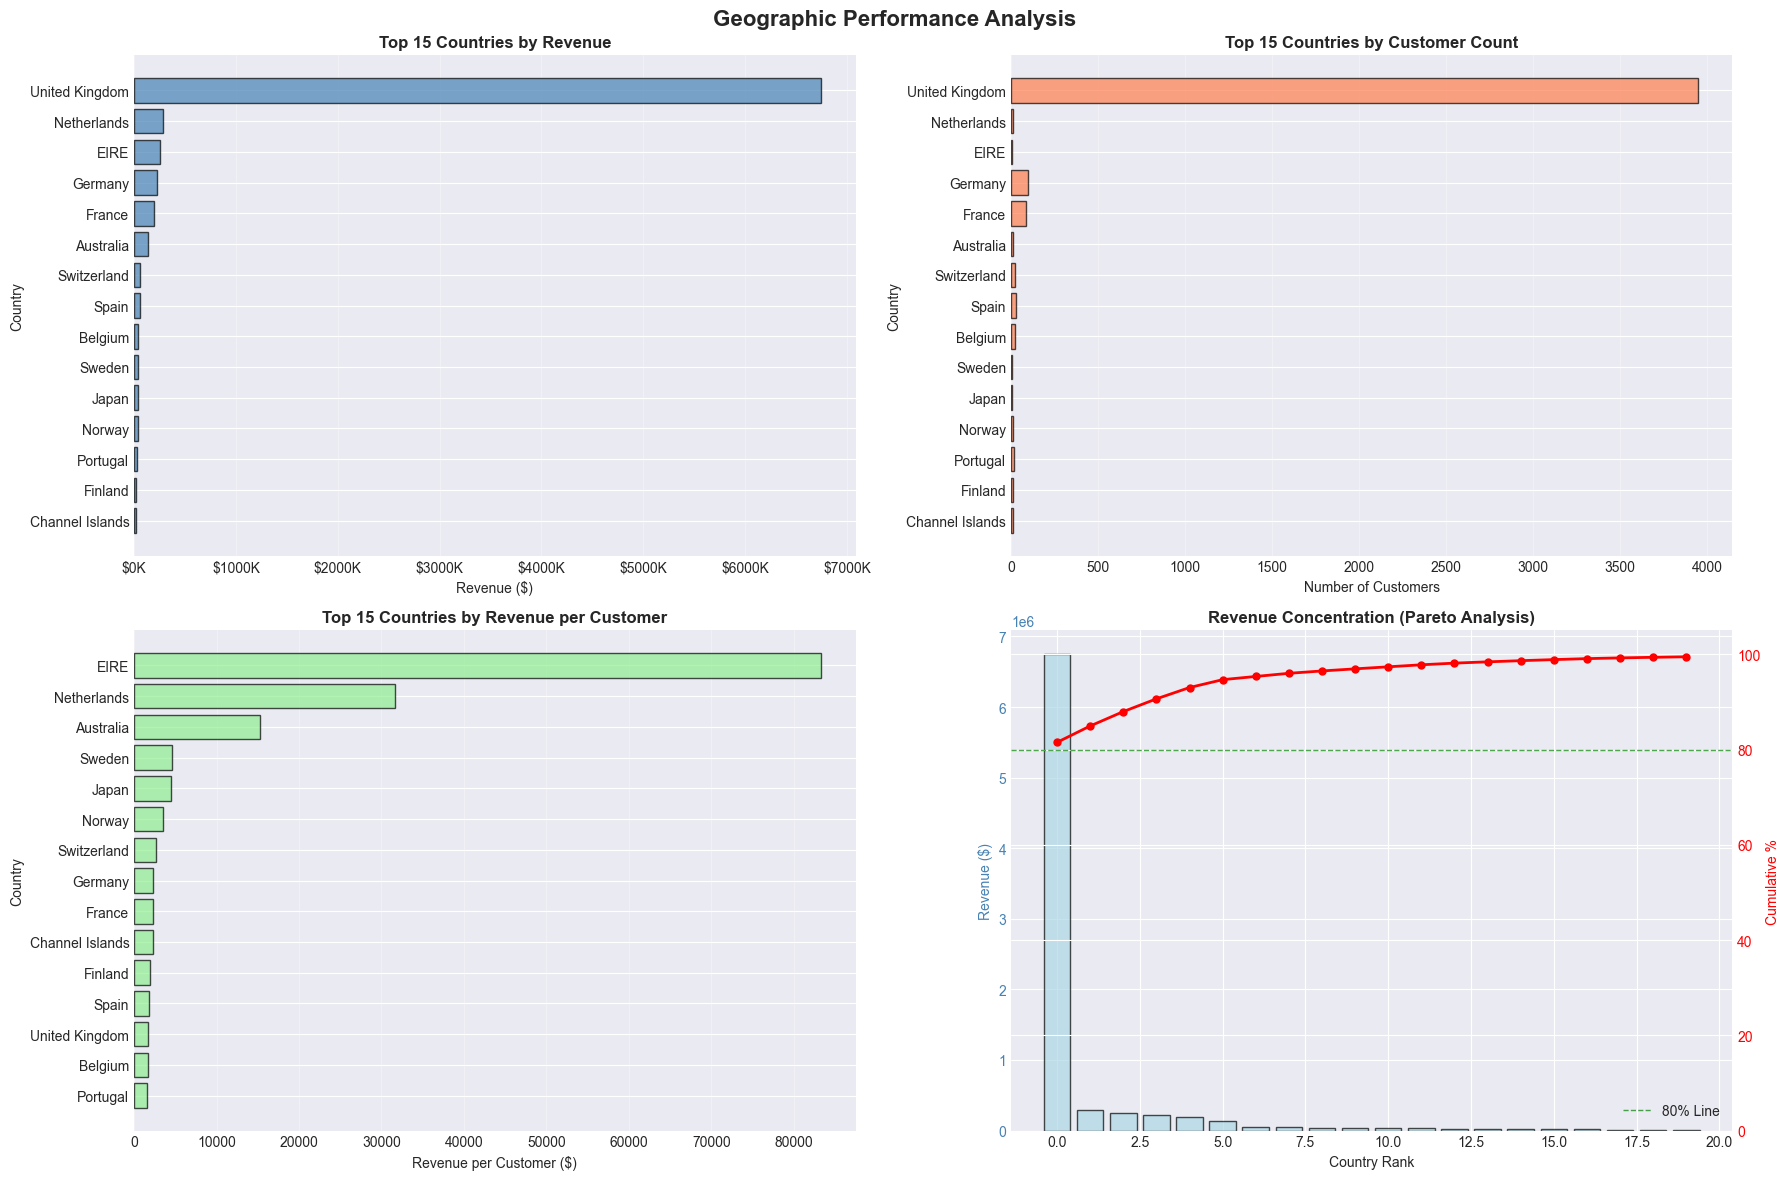

✅ Geographic analysis plots created and saved!

💡 GEOGRAPHIC KEY INSIGHTS:
----------------------------------------------------------------------
Top Country: United Kingdom
  - Revenue: $6,747,156.15
  - Customers: 3,949
  - Revenue Share: 81.50%

Pareto Principle: 0 countries generate 80% of revenue



In [20]:
# ============================================================
# STEP 19: GEOGRAPHIC ANALYSIS
# ============================================================

print("\n🌍 GEOGRAPHIC ANALYSIS")
print("=" * 70)

# Aggregate by country
country_stats = df.groupby('Country').agg({
    'CustomerID': 'nunique',
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum',
    'Quantity': 'sum'
}).reset_index()

country_stats.columns = ['Country', 'Customers', 'Orders', 'Revenue', 'Items_Sold']
country_stats = country_stats.sort_values('Revenue', ascending=False)

# Top 15 countries
top_countries = country_stats.head(15)

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Geographic Performance Analysis', fontsize=16, fontweight='bold')

# 1. Top 15 Countries by Revenue
axes[0, 0].barh(top_countries['Country'], top_countries['Revenue'], 
                color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Top 15 Countries by Revenue', fontweight='bold')
axes[0, 0].set_xlabel('Revenue ($)')
axes[0, 0].set_ylabel('Country')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# 2. Top 15 Countries by Number of Customers
axes[0, 1].barh(top_countries['Country'], top_countries['Customers'], 
                color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Top 15 Countries by Customer Count', fontweight='bold')
axes[0, 1].set_xlabel('Number of Customers')
axes[0, 1].set_ylabel('Country')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Revenue per Customer by Country
top_countries['RevenuePerCustomer'] = top_countries['Revenue'] / top_countries['Customers']
top_rpc = top_countries.nlargest(15, 'RevenuePerCustomer')
axes[1, 0].barh(top_rpc['Country'], top_rpc['RevenuePerCustomer'], 
                color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Top 15 Countries by Revenue per Customer', fontweight='bold')
axes[1, 0].set_xlabel('Revenue per Customer ($)')
axes[1, 0].set_ylabel('Country')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Revenue Concentration (Pareto Chart)
country_stats_sorted = country_stats.sort_values('Revenue', ascending=False).reset_index(drop=True)
country_stats_sorted['Cumulative_Pct'] = (country_stats_sorted['Revenue'].cumsum() / 
                                           country_stats_sorted['Revenue'].sum() * 100)

ax1 = axes[1, 1]
ax2 = ax1.twinx()

# Bar chart
ax1.bar(range(min(20, len(country_stats_sorted))), 
        country_stats_sorted.head(20)['Revenue'], 
        color='lightblue', edgecolor='black', alpha=0.7)
ax1.set_ylabel('Revenue ($)', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_xlabel('Country Rank')
ax1.set_title('Revenue Concentration (Pareto Analysis)', fontweight='bold')

# Line chart
ax2.plot(range(min(20, len(country_stats_sorted))), 
         country_stats_sorted.head(20)['Cumulative_Pct'], 
         color='red', marker='o', linewidth=2, markersize=5)
ax2.set_ylabel('Cumulative %', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.axhline(y=80, color='green', linestyle='--', linewidth=1, alpha=0.7, label='80% Line')
ax2.legend(loc='lower right')
ax2.set_ylim(0, 105)

plt.tight_layout()
plt.savefig('../images/results/geographic_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Geographic analysis plots created and saved!")

# Print geographic insights
print("\n💡 GEOGRAPHIC KEY INSIGHTS:")
print("-" * 70)
print(f"Top Country: {country_stats.iloc[0]['Country']}")
print(f"  - Revenue: ${country_stats.iloc[0]['Revenue']:,.2f}")
print(f"  - Customers: {country_stats.iloc[0]['Customers']:,}")
print(f"  - Revenue Share: {(country_stats.iloc[0]['Revenue']/country_stats['Revenue'].sum()*100):.2f}%")

# 80/20 rule
countries_for_80_pct = (country_stats_sorted['Cumulative_Pct'] <= 80).sum()
print(f"\nPareto Principle: {countries_for_80_pct} countries generate 80% of revenue")

print("\n" + "=" * 70)


👥 CUSTOMER BEHAVIOR DEEP DIVE


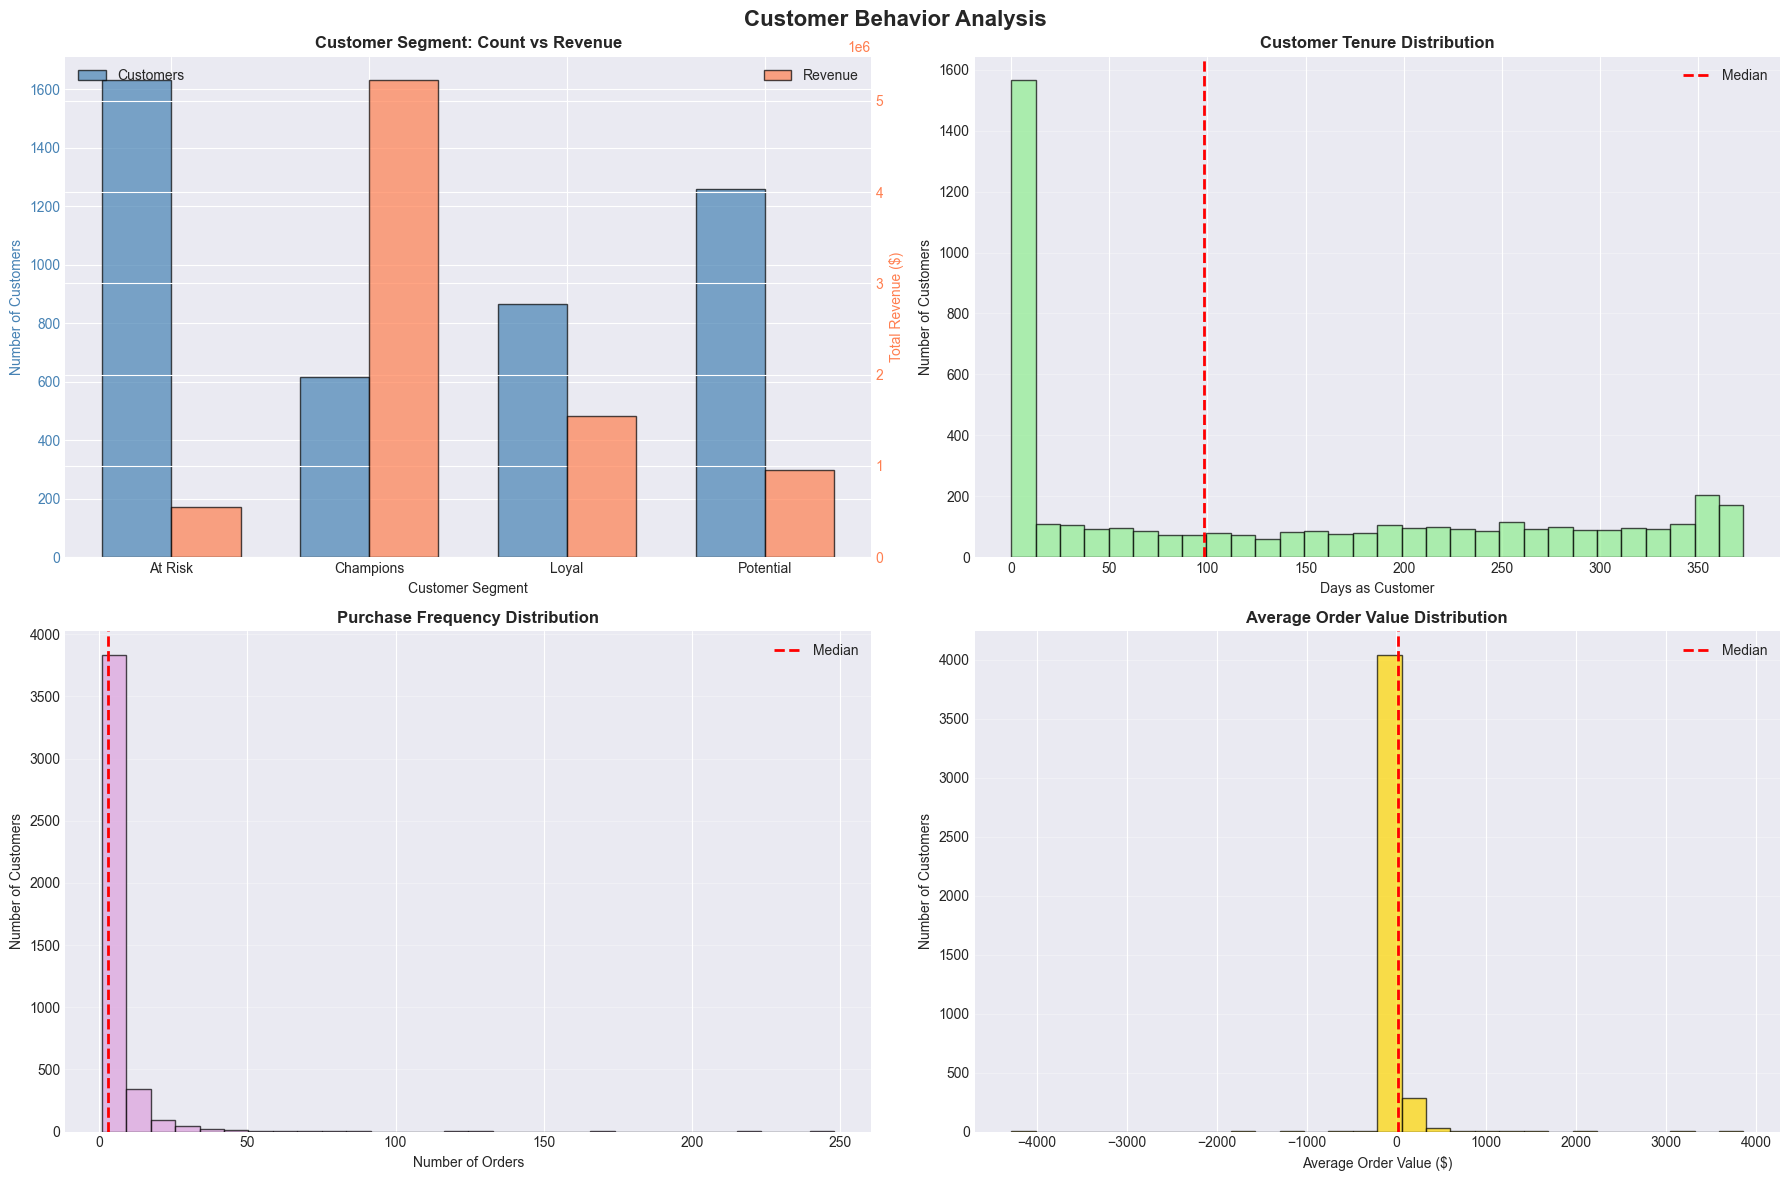

✅ Customer behavior plots created and saved!

📊 CUSTOMER METRICS:
----------------------------------------------------------------------
Total Customers: 4,371
Average Tenure: 133 days
Average Frequency: 5.08 orders
Average Order Value: $28.91
Median Monetary Value: $644.24



In [21]:
# ============================================================
# STEP 20: CUSTOMER BEHAVIOR DEEP DIVE
# ============================================================

print("\n👥 CUSTOMER BEHAVIOR DEEP DIVE")
print("=" * 70)

# Customer-level aggregation
customer_behavior = df.groupby('CustomerID').agg({
    'Recency': 'first',
    'Frequency': 'first',
    'Monetary': 'first',
    'RFMSegment': 'first',
    'CustomerTenure': 'max',
    'AvgOrderValue': 'first'
}).reset_index()

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Customer Behavior Analysis', fontsize=16, fontweight='bold')

# 1. RFM Segment Distribution with Values
segment_analysis = customer_behavior.groupby('RFMSegment').agg({
    'CustomerID': 'count',
    'Monetary': 'sum'
}).reset_index()
segment_analysis.columns = ['Segment', 'Customer_Count', 'Total_Revenue']

x = np.arange(len(segment_analysis))
width = 0.35

ax1 = axes[0, 0]
ax2 = ax1.twinx()

bars1 = ax1.bar(x - width/2, segment_analysis['Customer_Count'], width, 
                label='Customers', color='steelblue', alpha=0.7, edgecolor='black')
bars2 = ax2.bar(x + width/2, segment_analysis['Total_Revenue'], width, 
                label='Revenue', color='coral', alpha=0.7, edgecolor='black')

ax1.set_xlabel('Customer Segment')
ax1.set_ylabel('Number of Customers', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax2.set_ylabel('Total Revenue ($)', color='coral')
ax2.tick_params(axis='y', labelcolor='coral')
ax1.set_title('Customer Segment: Count vs Revenue', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(segment_analysis['Segment'])
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 2. Customer Tenure Distribution
axes[0, 1].hist(customer_behavior['CustomerTenure'], bins=30, 
                color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Customer Tenure Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Days as Customer')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].axvline(customer_behavior['CustomerTenure'].median(), 
                   color='red', linestyle='--', linewidth=2, label='Median')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Purchase Frequency Distribution
axes[1, 0].hist(customer_behavior['Frequency'], bins=30, 
                color='plum', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Purchase Frequency Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Number of Orders')
axes[1, 0].set_ylabel('Number of Customers')
axes[1, 0].axvline(customer_behavior['Frequency'].median(), 
                   color='red', linestyle='--', linewidth=2, label='Median')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Average Order Value Distribution
axes[1, 1].hist(customer_behavior['AvgOrderValue'], bins=30, 
                color='gold', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Average Order Value Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Average Order Value ($)')
axes[1, 1].set_ylabel('Number of Customers')
axes[1, 1].axvline(customer_behavior['AvgOrderValue'].median(), 
                   color='red', linestyle='--', linewidth=2, label='Median')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../images/results/customer_behavior.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Customer behavior plots created and saved!")

# Print customer insights
print("\n📊 CUSTOMER METRICS:")
print("-" * 70)
print(f"Total Customers: {len(customer_behavior):,}")
print(f"Average Tenure: {customer_behavior['CustomerTenure'].mean():.0f} days")
print(f"Average Frequency: {customer_behavior['Frequency'].mean():.2f} orders")
print(f"Average Order Value: ${customer_behavior['AvgOrderValue'].mean():,.2f}")
print(f"Median Monetary Value: ${customer_behavior['Monetary'].median():,.2f}")

print("\n" + "=" * 70)

In [22]:
# ============================================================
# STEP 21: COMPREHENSIVE BUSINESS INSIGHTS
# ============================================================

print("\n💼 COMPREHENSIVE BUSINESS INSIGHTS")
print("=" * 70)

print("\n🎯 KEY FINDINGS SUMMARY:")
print("=" * 70)

# 1. Revenue Insights
total_revenue = df['TotalAmount'].sum()
total_orders = df['InvoiceNo'].nunique()
total_customers = df['CustomerID'].nunique()
total_products = df['StockCode'].nunique()

print("\n1️⃣ OVERALL PERFORMANCE:")
print("-" * 70)
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Total Orders: {total_orders:,}")
print(f"Total Customers: {total_customers:,}")
print(f"Total Products: {total_products:,}")
print(f"Average Order Value: ${(total_revenue/total_orders):,.2f}")
print(f"Average Revenue per Customer: ${(total_revenue/total_customers):,.2f}")

# 2. Customer Segmentation Insights
print("\n2️⃣ CUSTOMER SEGMENTATION:")
print("-" * 70)
segment_dist = df.groupby(['CustomerID', 'RFMSegment']).first().reset_index()
segment_counts = segment_dist['RFMSegment'].value_counts()
segment_revenue = segment_dist.groupby('RFMSegment')['Monetary'].sum()

for segment in segment_counts.index:
    pct = (segment_counts[segment] / len(segment_dist)) * 100
    rev_pct = (segment_revenue[segment] / segment_revenue.sum()) * 100
    print(f"{segment:12s}: {segment_counts[segment]:4,} customers ({pct:5.2f}%) | Revenue: ${segment_revenue[segment]:,.0f} ({rev_pct:5.2f}%)")

# 3. Geographic Insights
print("\n3️⃣ GEOGRAPHIC CONCENTRATION:")
print("-" * 70)
top_country_rev = country_stats.iloc[0]['Revenue']
top_country_pct = (top_country_rev / country_stats['Revenue'].sum()) * 100
print(f"Top Market: {country_stats.iloc[0]['Country']}")
print(f"  Revenue Contribution: {top_country_pct:.2f}%")
print(f"  Number of Markets: {len(country_stats)}")

# 4. Temporal Insights
print("\n4️⃣ TEMPORAL PATTERNS:")
print("-" * 70)
best_month = df.groupby('MonthName')['TotalAmount'].sum().idxmax()
best_day = df.groupby('DayName')['TotalAmount'].sum().idxmax()
best_hour = df.groupby('Hour')['TotalAmount'].sum().idxmax()
print(f"Peak Month: {best_month}")
print(f"Peak Day: {best_day}")
print(f"Peak Hour: {best_hour}:00")

# 5. Product Insights
print("\n5️⃣ PRODUCT INSIGHTS:")
print("-" * 70)
return_rate = (df['IsReturn'].sum() / len(df)) * 100
print(f"Return Rate: {return_rate:.2f}%")
avg_items_per_order = df.groupby('InvoiceNo')['Quantity'].sum().mean()
print(f"Avg Items per Order: {avg_items_per_order:.2f}")

print("\n" + "=" * 70)


💼 COMPREHENSIVE BUSINESS INSIGHTS

🎯 KEY FINDINGS SUMMARY:

1️⃣ OVERALL PERFORMANCE:
----------------------------------------------------------------------
Total Revenue: $8,278,519.42
Total Orders: 22,186
Total Customers: 4,371
Total Products: 3,684
Average Order Value: $373.14
Average Revenue per Customer: $1,893.96

2️⃣ CUSTOMER SEGMENTATION:
----------------------------------------------------------------------
At Risk     : 1,631 customers (37.31%) | Revenue: $550,894 ( 6.65%)
Potential   : 1,258 customers (28.78%) | Revenue: $956,656 (11.56%)
Loyal       :  865 customers (19.79%) | Revenue: $1,547,109 (18.69%)
Champions   :  617 customers (14.12%) | Revenue: $5,223,860 (63.10%)

3️⃣ GEOGRAPHIC CONCENTRATION:
----------------------------------------------------------------------
Top Market: United Kingdom
  Revenue Contribution: 81.50%
  Number of Markets: 37

4️⃣ TEMPORAL PATTERNS:
----------------------------------------------------------------------
Peak Month: November
Peak D

In [23]:
# ============================================================
# STEP 22: SAVE ENHANCED DATASET & SUMMARY
# ============================================================

print("\n💾 FINALIZING PHASE 3")
print("=" * 70)

# Ensure enhanced dataset is saved
print("\n1️⃣ Verifying saved files...")
import os

files_created = []
if os.path.exists('../data/processed/ecommerce_data_enhanced.csv'):
    files_created.append('✅ Enhanced dataset')
else:
    df.to_csv('../data/processed/ecommerce_data_enhanced.csv', index=False)
    files_created.append('✅ Enhanced dataset (saved now)')

# Check images
image_files = [
    'distributions.png',
    'boxplots.png',
    'categorical_analysis.png',
    'correlation_heatmap.png',
    'scatter_plots.png',
    'categorical_revenue_analysis.png',
    'daily_trends.png',
    'monthly_trends.png',
    'seasonality_analysis.png',
    'geographic_analysis.png',
    'customer_behavior.png'
]

for img in image_files:
    if os.path.exists(f'../images/results/{img}'):
        files_created.append(f'✅ {img}')

print("\n📁 Files Created:")
for f in files_created:
    print(f"   {f}")

print("\n2️⃣ Phase 3 Statistics:")
print(f"   - Total Features Created: {len(df.columns)}")
print(f"   - Visualizations Created: {len(image_files)}")
print(f"   - Dataset Size: {len(df):,} rows")

print("\n" + "=" * 70)
print("🎉 PHASE 3 COMPLETE!")
print("=" * 70)
print("\nNext: Save and commit to GitHub!")


💾 FINALIZING PHASE 3

1️⃣ Verifying saved files...

📁 Files Created:
   ✅ Enhanced dataset
   ✅ distributions.png
   ✅ boxplots.png
   ✅ categorical_analysis.png
   ✅ correlation_heatmap.png
   ✅ scatter_plots.png
   ✅ categorical_revenue_analysis.png
   ✅ daily_trends.png
   ✅ monthly_trends.png
   ✅ seasonality_analysis.png
   ✅ geographic_analysis.png
   ✅ customer_behavior.png

2️⃣ Phase 3 Statistics:
   - Total Features Created: 36
   - Visualizations Created: 11
   - Dataset Size: 401,564 rows

🎉 PHASE 3 COMPLETE!

Next: Save and commit to GitHub!
